In [1827]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from autogluon.tabular import TabularPredictor
import random
import re
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score




### Read in all Compact and Detailed Results for Regular Season & Tournament Games

In [1828]:
# This df contains information about the regular season games for each team at a compact
men_regular_season_game_results = pd.read_csv('Men/MRegularSeasonCompactResults.csv')

# This df contains information about the regular season games for each team at a detailed level
men_regular_season_detailed_game_results = pd.read_csv('Men/MRegularSeasonDetailedResults.csv')

# This df contains information about the regular season games for each team at a compact level 
men_tournament_season_game_results = pd.read_csv('Men/MNCAATourneyCompactResults.csv')

# This df contains information about the regular season games for each team at a detailed level
men_tournament_stats = pd.read_csv('Men/MNCAATourneyDetailedResults.csv')

# This df contains information about the seeds of each team throughout the years of the NCAA tournament
men_tournament_seeds = pd.read_csv('Men/MNCAATourneySeeds.csv')

# This df contains information about the teams competing in the NCAA tournament
men_teams = pd.read_csv('Men/MTeams.csv')

# Duplicate of the men_teams
mteams = pd.read_csv('Men/MTeams.csv')

In [1829]:
# To better adjust for the 2025 season, we need to take a look at the seeds for the 2025 season
men_tournament_seeds_2025 = men_tournament_seeds[men_tournament_seeds['Season'] == 2025]
men_tournament_seeds_2025

,Season,Seed,TeamID
2558,2025,W01,1181
2559,2025,W02,1104
2560,2025,W03,1458
2561,2025,W04,1112
2562,2025,W05,1332
...,...,...,...
2621,2025,Z12,1161
2622,2025,Z13,1213
2623,2025,Z14,1423
2624,2025,Z15,1303


In [1830]:
men_regular_season_detailed_game_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

# Exploratory Data Analysis

### Distribution of Tournament and Regular Season Games Since 2022

In [1831]:
# I am interested in seeing the distribution of scores for the tournament games after 2022
# I chose 2022 to give me a better idea of the current state of the game and how many points teams usually score to win a game
men_regular_season_after_2022 = men_regular_season_game_results[men_regular_season_game_results['Season'] >= 2022]
winning_scores_regular_season = men_regular_season_after_2022['WScore']
losing_scores_regular_season = men_regular_season_after_2022['LScore']

# I am interested in seeing the distribution of scores for the and tournament games after 2022
men_tournament_after_2022 = men_tournament_season_game_results[men_tournament_season_game_results['Season'] >= 2022]
winning_scores_tournament = men_tournament_after_2022['WScore']
losing_scores_tournament = men_tournament_after_2022['LScore']

# Histogram for the distribution of scores that combines the regular season and tournament games
fig = go.Figure()
fig.add_trace(go.Histogram(x=winning_scores_regular_season, nbinsx=50, opacity=0.5, name="Regular Season Winning Scores"))
fig.add_trace(go.Histogram(x=losing_scores_regular_season, nbinsx=50, opacity=0.5, name="Regular Season Losing Scores"))
fig.add_trace(go.Histogram(x=winning_scores_tournament, nbinsx=50, opacity=0.5, name="Tournament Winning Scores"))
fig.add_trace(go.Histogram(x=losing_scores_tournament, nbinsx=50, opacity=0.5, name="Tournament Losing Scores"))
fig.update_layout(
    title="Distribution of Scores",
    barmode="overlay",  
    xaxis_title="Score",
    yaxis_title="Count",
)

# Show the histogram
fig.show()


To get a better understanding of the data, I decided to take a look at the distribution of scores for the tournament and regular season games after the 2022 season. I just wanted a quick peak into the typical scores that winning and losing teams have in the tournament and regular season games. In the tournament, usually if a team scores above 78 points, they more than likely ended up winning the game. 

The goal here is to create a dataframe where we can analyze how the seed has impacted the outcome of the game since 1985 . We will merge the men_tournament_seeds table with the tournament games on the Season and WTeamID columns and then merge again on the LTeamID column. This will give us the winning and losing seeds for each game 

In [1832]:
# The goal here is to create a dataframe where we can analyze how the seed has impacted the outcome of the game since 1985 
# We will merge the men_tournament_seeds table with the tournament games on the Season and WTeamID columns and then merge again on the LTeamID column
# This will give us the winning and losing seeds for each game 
merged_df = men_tournament_season_game_results.merge(
    men_tournament_seeds,
    how="left",
    left_on=["Season", "WTeamID"],
    right_on=["Season", "TeamID"]
).rename(columns={"Seed": "WSeed"}).drop(columns=["TeamID"])

# Merge again to get the losing seed
upset_analysis = merged_df.merge(
    men_tournament_seeds,
    how="left",
    left_on=["Season", "LTeamID"],
    right_on=["Season", "TeamID"]
).rename(columns={"Seed": "LSeed"}).drop(columns=["TeamID"])

# Here we construct a new feature called SeedDiff which is the difference between the winning seed and losing seed
# This will give us an idea of how much of an upset the game was
upset_analysis['WSeed'] = upset_analysis['WSeed'].str.extract('(\d+)').astype(int)
upset_analysis['LSeed'] = upset_analysis['LSeed'].str.extract('(\d+)').astype(int)
upset_analysis['SeedDiff'] = upset_analysis['WSeed'] - upset_analysis['LSeed']

# Now we can get the Margin of Victory (MOV) which is the difference between the winning score and losing score
# This tells us how much the winning team won by
upset_analysis['MOV'] = upset_analysis['WScore'] - upset_analysis['LScore']

# Here we merge on the men_teams table to get the winning team name and losing team name instead of just looking at the TeamID
upset_analysis = upset_analysis.merge(
    men_teams[['TeamID', 'TeamName']], 
    how="left",
    left_on="WTeamID",
    right_on="TeamID"
).rename(columns={"TeamName": "WTeamName"}).drop(columns=["TeamID"])

# Merge again to get the losing team name
upset_analysis = upset_analysis.merge(
    men_teams[['TeamID', 'TeamName']],  
    how="left",
    left_on="LTeamID",
    right_on="TeamID"
).rename(columns={"TeamName": "LTeamName"}).drop(columns=["TeamID"])

upset_analysis

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,SeedDiff,MOV,WTeamName,LTeamName
0,1985,136,1116,63,1234,54,N,0,9,8,1,9,Arkansas,Iowa
1,1985,136,1120,59,1345,58,N,0,11,6,5,1,Auburn,Purdue
2,1985,136,1207,68,1250,43,N,0,1,16,-15,25,Georgetown,Lehigh
3,1985,136,1229,58,1425,55,N,0,9,8,1,3,Illinois St,USC
4,1985,136,1242,49,1325,38,N,0,3,14,-11,11,Kansas,Ohio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0,11,4,7,12,NC State,Duke
2514,2024,146,1345,72,1397,66,N,0,1,2,-1,6,Purdue,Tennessee
2515,2024,152,1163,86,1104,72,N,0,1,4,-3,14,Connecticut,Alabama
2516,2024,152,1345,63,1301,50,N,0,1,11,-10,13,Purdue,NC State


### Histogram of Distribution of Seed Differences

In [1833]:
# Histogram to understand the impact of seed difference on the outcome of the game
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=upset_analysis['SeedDiff'],
        nbinsx=20,
        opacity=0.5,
        name="Seed Difference"
    )
)
fig.update_traces(
    texttemplate="%{y}",
    textposition="outside",
    marker=dict(
        line=dict(width=1, color='DarkSlateGrey')
    )
)
fig.update_layout(
    title="Distribution of Seed Differences",
    xaxis_title="Seed Difference",
    yaxis_title="Count",
    bargap=0.1
)
fig.show()


Based on the distribution of seed differences histogram: 
1. Most games have a negative seed difference (left-skewed distribution). A negative seed difference means that the winning team had a better (lower) seed than the losing team.  
2. Some upsets occur (positive seed difference). There are instances where the seed difference is positive, meaning that a lower-seede team defeated a higher seeded team. 
3. Bottom line, favorites tend to win, but Cinderlla stories still exist! 

### Violin Plots of MOV by Seed Difference 

In [1834]:
# Violin plot that shows the distribution of margin of victory for each seed difference
fig = go.Figure()
fig.add_trace(go.Violin(
    x=upset_analysis['SeedDiff'],
    y=upset_analysis['MOV'],
    box_visible=True,
    meanline_visible=True,
    points="all",       
    jitter=0.3,       
    opacity=0.6,
    name="Margin of Victory",
    hoverinfo="x+y"     
))
fig.update_layout(
    title="Distribution of Margin of Victory by Seed Difference",
    xaxis_title="Seed Difference",
    yaxis_title="Margin of Victory",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)
fig.show()


Some of the observations that I can draw from the Distribution of Margin of Victory by Seed Difference violin plots: 
1. Wide Range of Margins for Negative Seed Differences - When the winning team has a lower seed, there are times where there are large spread of MOV leading to blowouts. 
2. Upsets Tend to Have Lower to Moderate Margins - Even though upsets occur, they tend to happen via a smaller margin, rather than a high MOV (blowout). 
3. Close Seeds (SeedDiff Near Zero) Still Show Variation - Two teams with close seeds can still produce both very tight games 

In [1835]:
def get_round(daynum):
    """
    Purpose: Get the round of the tournament based on the day number
    Input: daynum (int) - the day number of the tournament
    Output: round (str) - the round of the tournament
    """
    if 134 <= daynum <= 135:
        return "Play-in"
    elif 136 <= daynum <= 137:
        return "Round 1 (64 Teams)"
    elif 138 <= daynum <= 139:
        return "Round 2 (32 Teams)"
    elif 143 <= daynum <= 144:
        return "Sweet 16"
    elif 145 <= daynum <= 146:
        return "Elite Eight"
    elif daynum == 152:
        return "Final Four"
    elif daynum == 154:
        return "Championship"
    else:
        return "Unknown"

# Apply function to apply the get_round function to the DayNum column
upset_analysis["Round"] = upset_analysis["DayNum"].apply(get_round)
upset_analysis

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,SeedDiff,MOV,WTeamName,LTeamName,Round
0,1985,136,1116,63,1234,54,N,0,9,8,1,9,Arkansas,Iowa,Round 1 (64 Teams)
1,1985,136,1120,59,1345,58,N,0,11,6,5,1,Auburn,Purdue,Round 1 (64 Teams)
2,1985,136,1207,68,1250,43,N,0,1,16,-15,25,Georgetown,Lehigh,Round 1 (64 Teams)
3,1985,136,1229,58,1425,55,N,0,9,8,1,3,Illinois St,USC,Round 1 (64 Teams)
4,1985,136,1242,49,1325,38,N,0,3,14,-11,11,Kansas,Ohio,Round 1 (64 Teams)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0,11,4,7,12,NC State,Duke,Elite Eight
2514,2024,146,1345,72,1397,66,N,0,1,2,-1,6,Purdue,Tennessee,Elite Eight
2515,2024,152,1163,86,1104,72,N,0,1,4,-3,14,Connecticut,Alabama,Final Four
2516,2024,152,1345,63,1301,50,N,0,1,11,-10,13,Purdue,NC State,Final Four


### Line Plot of Win Percentage Each Seed by Round Since 2000 

In [1836]:
# Now we need to plot the win percetage of each seed by round since 2020
# I chose 2020 because I only wanted to see the most recent data. The game changes every year and we see more 3-pointers and faster pace of play 
# I am interested in seeing how the win percentage of each seed changes as the tournament progresses
# This will give me an idea of how likely a seed is to win a game in each round
men_tournament_season_game_results_2020 = upset_analysis[men_tournament_season_game_results['Season'] >= 2020]

# Count the number of wins per seed per round
wins_by_seed_round = men_tournament_season_game_results_2020.groupby(["WSeed", "Round"]).size().unstack(fill_value=0)

# Count total games played by each seed in each round (WSeed and LSeed both participated in a game)
total_games_by_seed_round = men_tournament_season_game_results_2020.groupby(["LSeed", "Round"]).size().unstack(fill_value=0) + wins_by_seed_round

# Compute win percentage per round for each seed
seed_win_percentage = (wins_by_seed_round / total_games_by_seed_round).fillna(0)

# List that contains all of the rounds in order
all_rounds = ["Round 1 (64 Teams)", "Round 2 (32 Teams)", "Sweet 16", "Elite Eight", "Final Four", "Championship"]

# Reindex to ensure every seed has all rounds
seed_win_percentage = seed_win_percentage.reindex(columns=all_rounds, fill_value=0)

# Now we can plot the win percentage of each seed by round
fig = go.Figure()
# For each seed in the seed_win_percentage dataframe, plot the win percentage by round
for seed in seed_win_percentage.index:
    fig.add_trace(go.Scatter(
        x=all_rounds, 
        y=seed_win_percentage.loc[seed], 
        mode='lines+markers',  
        name=f"Seed {seed}"
    ))
fig.update_xaxes(categoryorder="array", categoryarray=all_rounds)
fig.update_layout(
    title="Win Percentage of Each Seed by Round Since 2020",
    xaxis_title="Round",
    yaxis_title="Win Percentage",
    showlegend=True
)

fig.show()

I chose to visualize win percetnage of each seed since 2020 because I interested in only seeing the most recent data. The game changes every year and we continue to see more 3-pointers and faster pace of play each year. A couple of interesting observations I made: 
1. Typically the top 4 seeds of each conference tend to win the first round (> 80%)
2. The 7th seed has won roughly 72% of the time in round 1. 
3. The 14th seed has only won 7% of the time in round 1. 
4. The 1 seed and 4 seeds are the only seeds that have won the NCAA tournament since 2020. 

# Data Manipulation for Historical Model 

In [1837]:
# Now we need to get the number of victories that each team had in the tournament since the inception in 1985
# Here we group by the Team Name and Season and count the number of victories for that particular season 
tournament_wins = upset_analysis.groupby("WTeamName")['Season'].count().reset_index()
tournament_wins.columns = ["TeamID", "NCAA_Wins"]

# Now we do the same for the losing team. We get group by the LTeamName and count the number of losses for that particular season
tournament_losses = upset_analysis.groupby("LTeamName")['Season'].count().reset_index()
tournament_losses.columns = ["TeamID", "NCAA_Losses"]

# Here we merge the two dataframes to get the total number of wins and losses for each team
tournament_wins_and_losses = tournament_wins.merge(tournament_losses, on="TeamID", how="outer").fillna(0)
# To calculate the NCAA Win Percentage, we divide the number of wins by the total number of games played
tournament_wins_and_losses["NCAA_Win_Percentage"] = tournament_wins_and_losses["NCAA_Wins"] / (tournament_wins_and_losses["NCAA_Wins"] + tournament_wins_and_losses["NCAA_Losses"])

# Now we take the tournmanet_wins_and_losses dataframe and merge it with the upset_analysis dataframe to get the number of wins, losses, and win percentage for each team
# We do this for both the winning team and losing team
upset_analysis = upset_analysis.merge(
    tournament_wins_and_losses, 
    how="left",
    left_on="WTeamName",
    right_on="TeamID"
).rename(columns={"NCAA_Wins": "WTeamNCAA_Wins", "NCAA_Losses": "WTeamNCAA_Losses", "NCAA_Win_Percentage": "WTeamNCAA_Win_Percentage"}).drop(columns=["TeamID"])

# Merge again with the losing team
upset_analysis = upset_analysis.merge(
    tournament_wins_and_losses, 
    how="left",
    left_on="LTeamName",
    right_on="TeamID"
).rename(columns={"NCAA_Wins": "LTeamNCAA_Wins", "NCAA_Losses": "LTeamNCAA_Losses", "NCAA_Win_Percentage": "LTeamNCAA_Win_Percentage"}).drop(columns=["TeamID"])


In [1838]:
# We need to set the lower team as the lower team id 
upset_analysis['LowerTeamID'] = upset_analysis[['WTeamID', 'LTeamID']].min(axis=1)
upset_analysis['HigherTeamID'] = upset_analysis[['WTeamID', 'LTeamID']].max(axis=1)

# The ML algorithm will predict the lower team as the winner if the prediction is 1
# If the prediction is 0, the higher team will be the winner
upset_analysis['Target'] = (upset_analysis['LowerTeamID'] == upset_analysis['WTeamID']).astype(int)
upset_analysis

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,...,Round,WTeamNCAA_Wins,WTeamNCAA_Losses,WTeamNCAA_Win_Percentage,LTeamNCAA_Wins,LTeamNCAA_Losses,LTeamNCAA_Win_Percentage,LowerTeamID,HigherTeamID,Target
0,1985,136,1116,63,1234,54,N,0,9,8,...,Round 1 (64 Teams),38.0,22,0.633333,18.0,21,0.461538,1116,1234,1
1,1985,136,1120,59,1345,58,N,0,11,6,...,Round 1 (64 Teams),19.0,12,0.612903,40.0,30,0.571429,1120,1345,1
2,1985,136,1207,68,1250,43,N,0,1,16,...,Round 1 (64 Teams),33.0,22,0.600000,1.0,5,0.166667,1207,1250,1
3,1985,136,1229,58,1425,55,N,0,9,8,...,Round 1 (64 Teams),2.0,4,0.333333,12.0,15,0.444444,1229,1425,1
4,1985,136,1242,49,1325,38,N,0,3,14,...,Round 1 (64 Teams),94.0,35,0.728682,4.0,6,0.400000,1242,1325,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0,11,4,...,Elite Eight,23.0,18,0.560976,105.0,32,0.766423,1181,1301,0
2514,2024,146,1345,72,1397,66,N,0,1,2,...,Elite Eight,40.0,30,0.571429,23.0,18,0.560976,1345,1397,1
2515,2024,152,1163,86,1104,72,N,0,1,4,...,Final Four,67.0,18,0.788235,27.0,20,0.574468,1104,1163,0
2516,2024,152,1345,63,1301,50,N,0,1,11,...,Final Four,40.0,30,0.571429,23.0,18,0.560976,1301,1345,0


In [1839]:
# Now we need to get the regular season wins and losses and the PPG for each team since 2000
# Just like how we calculated the number of wins and losses for the tournament games, we will do the same for the regular season games
men_regular_season_game_results_since_1985 = men_regular_season_game_results[men_regular_season_game_results['Season'] >= 1985]
regular_season_wins = men_regular_season_game_results_since_1985.groupby("WTeamID")["Season"].count().reset_index()
regular_season_wins.columns = ["TeamID", "RegularSeason_Wins_Since_1985"]

# Here we gropu by the LTeamID to get the number of losses for each team
regular_season_losses = men_regular_season_game_results_since_1985.groupby("LTeamID")["Season"].count().reset_index()
regular_season_losses.columns = ["TeamID", "RegularSeason_Losses_Since_1985"]

# Now we merge the regular season wins and losses dataframes with the upset_analysis dataframe to get the number of wins and losses for each team
upset_analysis = upset_analysis.merge(
    regular_season_wins, 
    how="left",
    left_on="WTeamID",
    right_on="TeamID"
).rename(columns={"RegularSeason_Wins_Since_1985": "WTeamRegularSeason_Wins_Since_1985"}).drop(columns=["TeamID"])

# Merge again to get the number of losses for the winning team
upset_analysis = upset_analysis.merge(
    regular_season_losses, 
    how="left",
    left_on="WTeamID",
    right_on="TeamID"
).rename(columns={"RegularSeason_Losses_Since_1985": "WTeamRegularSeason_Losses_Since_1985"}).drop(columns=["TeamID"])

# Merge again to get the number of wins for the losing team
upset_analysis = upset_analysis.merge(
    regular_season_wins, 
    how="left",
    left_on="LTeamID",
    right_on="TeamID"
).rename(columns={"RegularSeason_Wins_Since_1985": "LTeamRegularSeason_Wins_Since_1985"}).drop(columns=["TeamID"])

# Merge again to get the number of losses for the losing team
upset_analysis = upset_analysis.merge(
    regular_season_losses, 
    how="left",
    left_on="LTeamID",
    right_on="TeamID"
).rename(columns={"RegularSeason_Losses_Since_1985": "LTeamRegularSeason_Losses_Since_1985"}).drop(columns=["TeamID"])

In [1840]:
# I am interested in creating features that will help us understand the experience of each team in the tournament
# We will create features that will help us understand how deep each team has gone in the tournament

# Binary Indicators for each round 
upset_analysis["Sweet16_Appearance"] = (upset_analysis["Round"] == "Sweet 16").astype(int)
upset_analysis["Elite8_Appearance"] = (upset_analysis["Round"] == "Elite Eight").astype(int)
upset_analysis["Final4_Appearance"] = (upset_analysis["Round"] == "Final Four").astype(int)
upset_analysis["Championship_Appearance"] = (upset_analysis["Round"] == "Championship").astype(int)

# For each team, we will calculate the number of appearances in each round
round_appearances = upset_analysis.groupby("WTeamID")[
    ["Sweet16_Appearance", "Elite8_Appearance", "Final4_Appearance", "Championship_Appearance"]
].sum().reset_index()

# Rename columns
round_appearances.columns = ["TeamID", "Sweet16_Appearances", "Elite8_Appearances", "Final4_Appearances", "Championship_Appearances"]

# We will update our upset_analysis dataframe to include the number of appearances in each round for each team
upset_analysis = upset_analysis.merge(
    round_appearances, 
    how="left",
    left_on="WTeamID",
    right_on="TeamID"
).rename(columns={
    "Sweet16_Appearances": "W_Sweet16_Appearances",
    "Elite8_Appearances": "W_Elite8_Appearances",
    "Final4_Appearances": "W_Final4_Appearances",
    "Championship_Appearances": "W_Championship_Appearances"
}).drop(columns=["TeamID"])

# Merge again for the losing team
upset_analysis = upset_analysis.merge(
    round_appearances, 
    how="left",
    left_on="LTeamID",
    right_on="TeamID"
).rename(columns={
    "Sweet16_Appearances": "L_Sweet16_Appearances",
    "Elite8_Appearances": "L_Elite8_Appearances",
    "Final4_Appearances": "L_Final4_Appearances",
    "Championship_Appearances": "L_Championship_Appearances"
}).drop(columns=["TeamID"])

# We will create a new feature called W_DeepRun_Experience and L_DeepRun_Experience which is the sum of the appearances in each round
# This will give us an idea of how experienced each team is in the tournament
upset_analysis["W_DeepRun_Experience"] = (
    upset_analysis["W_Sweet16_Appearances"] * 1 + 
    upset_analysis["W_Elite8_Appearances"] * 2 + 
    upset_analysis["W_Final4_Appearances"] * 3 + 
    upset_analysis["W_Championship_Appearances"] * 4
)
# Same thing for the losing team
upset_analysis["L_DeepRun_Experience"] = (
    upset_analysis["L_Sweet16_Appearances"] * 1 + 
    upset_analysis["L_Elite8_Appearances"] * 2 + 
    upset_analysis["L_Final4_Appearances"] * 3 + 
    upset_analysis["L_Championship_Appearances"] * 4
)

# The difference between the winning team's deep run experience and the losing team's deep run experience is our new feature, DeepRun_Experience_Diff
upset_analysis["DeepRun_Experience_Diff"] = upset_analysis["W_DeepRun_Experience"] - upset_analysis["L_DeepRun_Experience"]


In [1841]:
upset_analysis

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,...,W_Elite8_Appearances,W_Final4_Appearances,W_Championship_Appearances,L_Sweet16_Appearances,L_Elite8_Appearances,L_Final4_Appearances,L_Championship_Appearances,W_DeepRun_Experience,L_DeepRun_Experience,DeepRun_Experience_Diff
0,1985,136,1116,63,1234,54,N,0,9,8,...,4,2,1,1.0,0.0,0.0,0.0,23,1.0,22.0
1,1985,136,1120,59,1345,58,N,0,11,6,...,1,0,0,4.0,1.0,1.0,0.0,4,9.0,-5.0
2,1985,136,1207,68,1250,43,N,0,1,16,...,2,1,0,0.0,0.0,0.0,0.0,12,0.0,12.0
3,1985,136,1229,58,1425,55,N,0,9,8,...,0,0,0,1.0,1.0,0.0,0.0,0,3.0,-3.0
4,1985,136,1242,49,1325,38,N,0,3,14,...,10,6,3,0.0,0.0,0.0,0.0,66,0.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0,11,4,...,1,0,0,18.0,13.0,9.0,5.0,5,91.0,-86.0
2514,2024,146,1345,72,1397,66,N,0,1,2,...,1,1,0,2.0,0.0,0.0,0.0,9,2.0,7.0
2515,2024,152,1163,86,1104,72,N,0,1,4,...,7,6,6,2.0,1.0,0.0,0.0,68,4.0,64.0
2516,2024,152,1345,63,1301,50,N,0,1,11,...,1,1,0,3.0,1.0,0.0,0.0,9,5.0,4.0


In [1842]:
# Now we want to merge the men_tournament_stats table with the upset_analysis table to get the stats for each team in the tournament
# We will merge on the Season, DayNum, WTeamID, and LTeamID columns
men_tourney_stats_filtered = men_tournament_stats.drop(columns=["WScore", "LScore", "WLoc", "NumOT"])
upset_analysis = upset_analysis.merge(
    men_tourney_stats_filtered, 
    how="left",  
    on=["Season", "DayNum", "WTeamID", "LTeamID"]
)

In [1843]:
# A key thing to note here is that we only have data starting from 2003 for the tournament stats. 
# We will only consider the data from 2003 onwards. I feel as if these stats will be more relevant to the current state of the game. 

# March Madness is a very form based tournament. Teams that are in form tend to do well in the tournament.
# The historical model will only be used to understand how seeds play a role in the outcome of the game.
upset_analysis

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,1985,136,1116,63,1234,54,N,0,9,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,136,1120,59,1345,58,N,0,11,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,136,1207,68,1250,43,N,0,1,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985,136,1229,58,1425,55,N,0,9,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985,136,1242,49,1325,38,N,0,3,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0,11,4,...,20.0,21.0,26.0,10.0,27.0,11.0,9.0,4.0,5.0,23.0
2514,2024,146,1345,72,1397,66,N,0,1,2,...,26.0,7.0,11.0,6.0,17.0,17.0,6.0,8.0,4.0,25.0
2515,2024,152,1163,86,1104,72,N,0,1,4,...,23.0,9.0,11.0,7.0,21.0,9.0,7.0,2.0,5.0,15.0
2516,2024,152,1345,63,1301,50,N,0,1,11,...,19.0,3.0,4.0,6.0,22.0,10.0,11.0,8.0,3.0,13.0


In [1844]:
# As mentioned before, we will now only consider the data from 2003 onwards
upset_analysis_since_2003 = upset_analysis[upset_analysis['Season'] >= 2003]

# Check for missing values
missing_values = upset_analysis_since_2003.isnull().sum()
missing_values = missing_values[missing_values > 0]

# We need to fill in the missing values with  0 
upset_analysis_since_2003 = upset_analysis_since_2003.fillna(0)

In [1845]:
# We need to check for non numerical features
non_numerical_features = upset_analysis_since_2003.select_dtypes(include=['object']).columns
non_numerical_features

Index(['WLoc', 'WTeamName', 'LTeamName', 'Round'], dtype='object')

In [1846]:
upset_analysis_since_2003

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
1136,2003,134,1421,92,1411,84,N,1,16,16,...,31.0,14.0,31.0,17.0,28.0,16.0,15.0,5.0,0.0,22.0
1137,2003,136,1112,80,1436,51,N,0,1,16,...,16.0,7.0,7.0,8.0,26.0,12.0,17.0,10.0,3.0,15.0
1138,2003,136,1113,84,1272,71,N,0,10,7,...,28.0,14.0,21.0,20.0,22.0,11.0,12.0,2.0,5.0,18.0
1139,2003,136,1141,79,1166,73,N,0,11,6,...,17.0,12.0,17.0,14.0,17.0,20.0,21.0,6.0,6.0,21.0
1140,2003,136,1143,76,1301,74,N,1,8,9,...,21.0,15.0,20.0,10.0,26.0,16.0,14.0,5.0,8.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0,11,4,...,20.0,21.0,26.0,10.0,27.0,11.0,9.0,4.0,5.0,23.0
2514,2024,146,1345,72,1397,66,N,0,1,2,...,26.0,7.0,11.0,6.0,17.0,17.0,6.0,8.0,4.0,25.0
2515,2024,152,1163,86,1104,72,N,0,1,4,...,23.0,9.0,11.0,7.0,21.0,9.0,7.0,2.0,5.0,15.0
2516,2024,152,1345,63,1301,50,N,0,1,11,...,19.0,3.0,4.0,6.0,22.0,10.0,11.0,8.0,3.0,13.0


### Correlation Matrix of Features

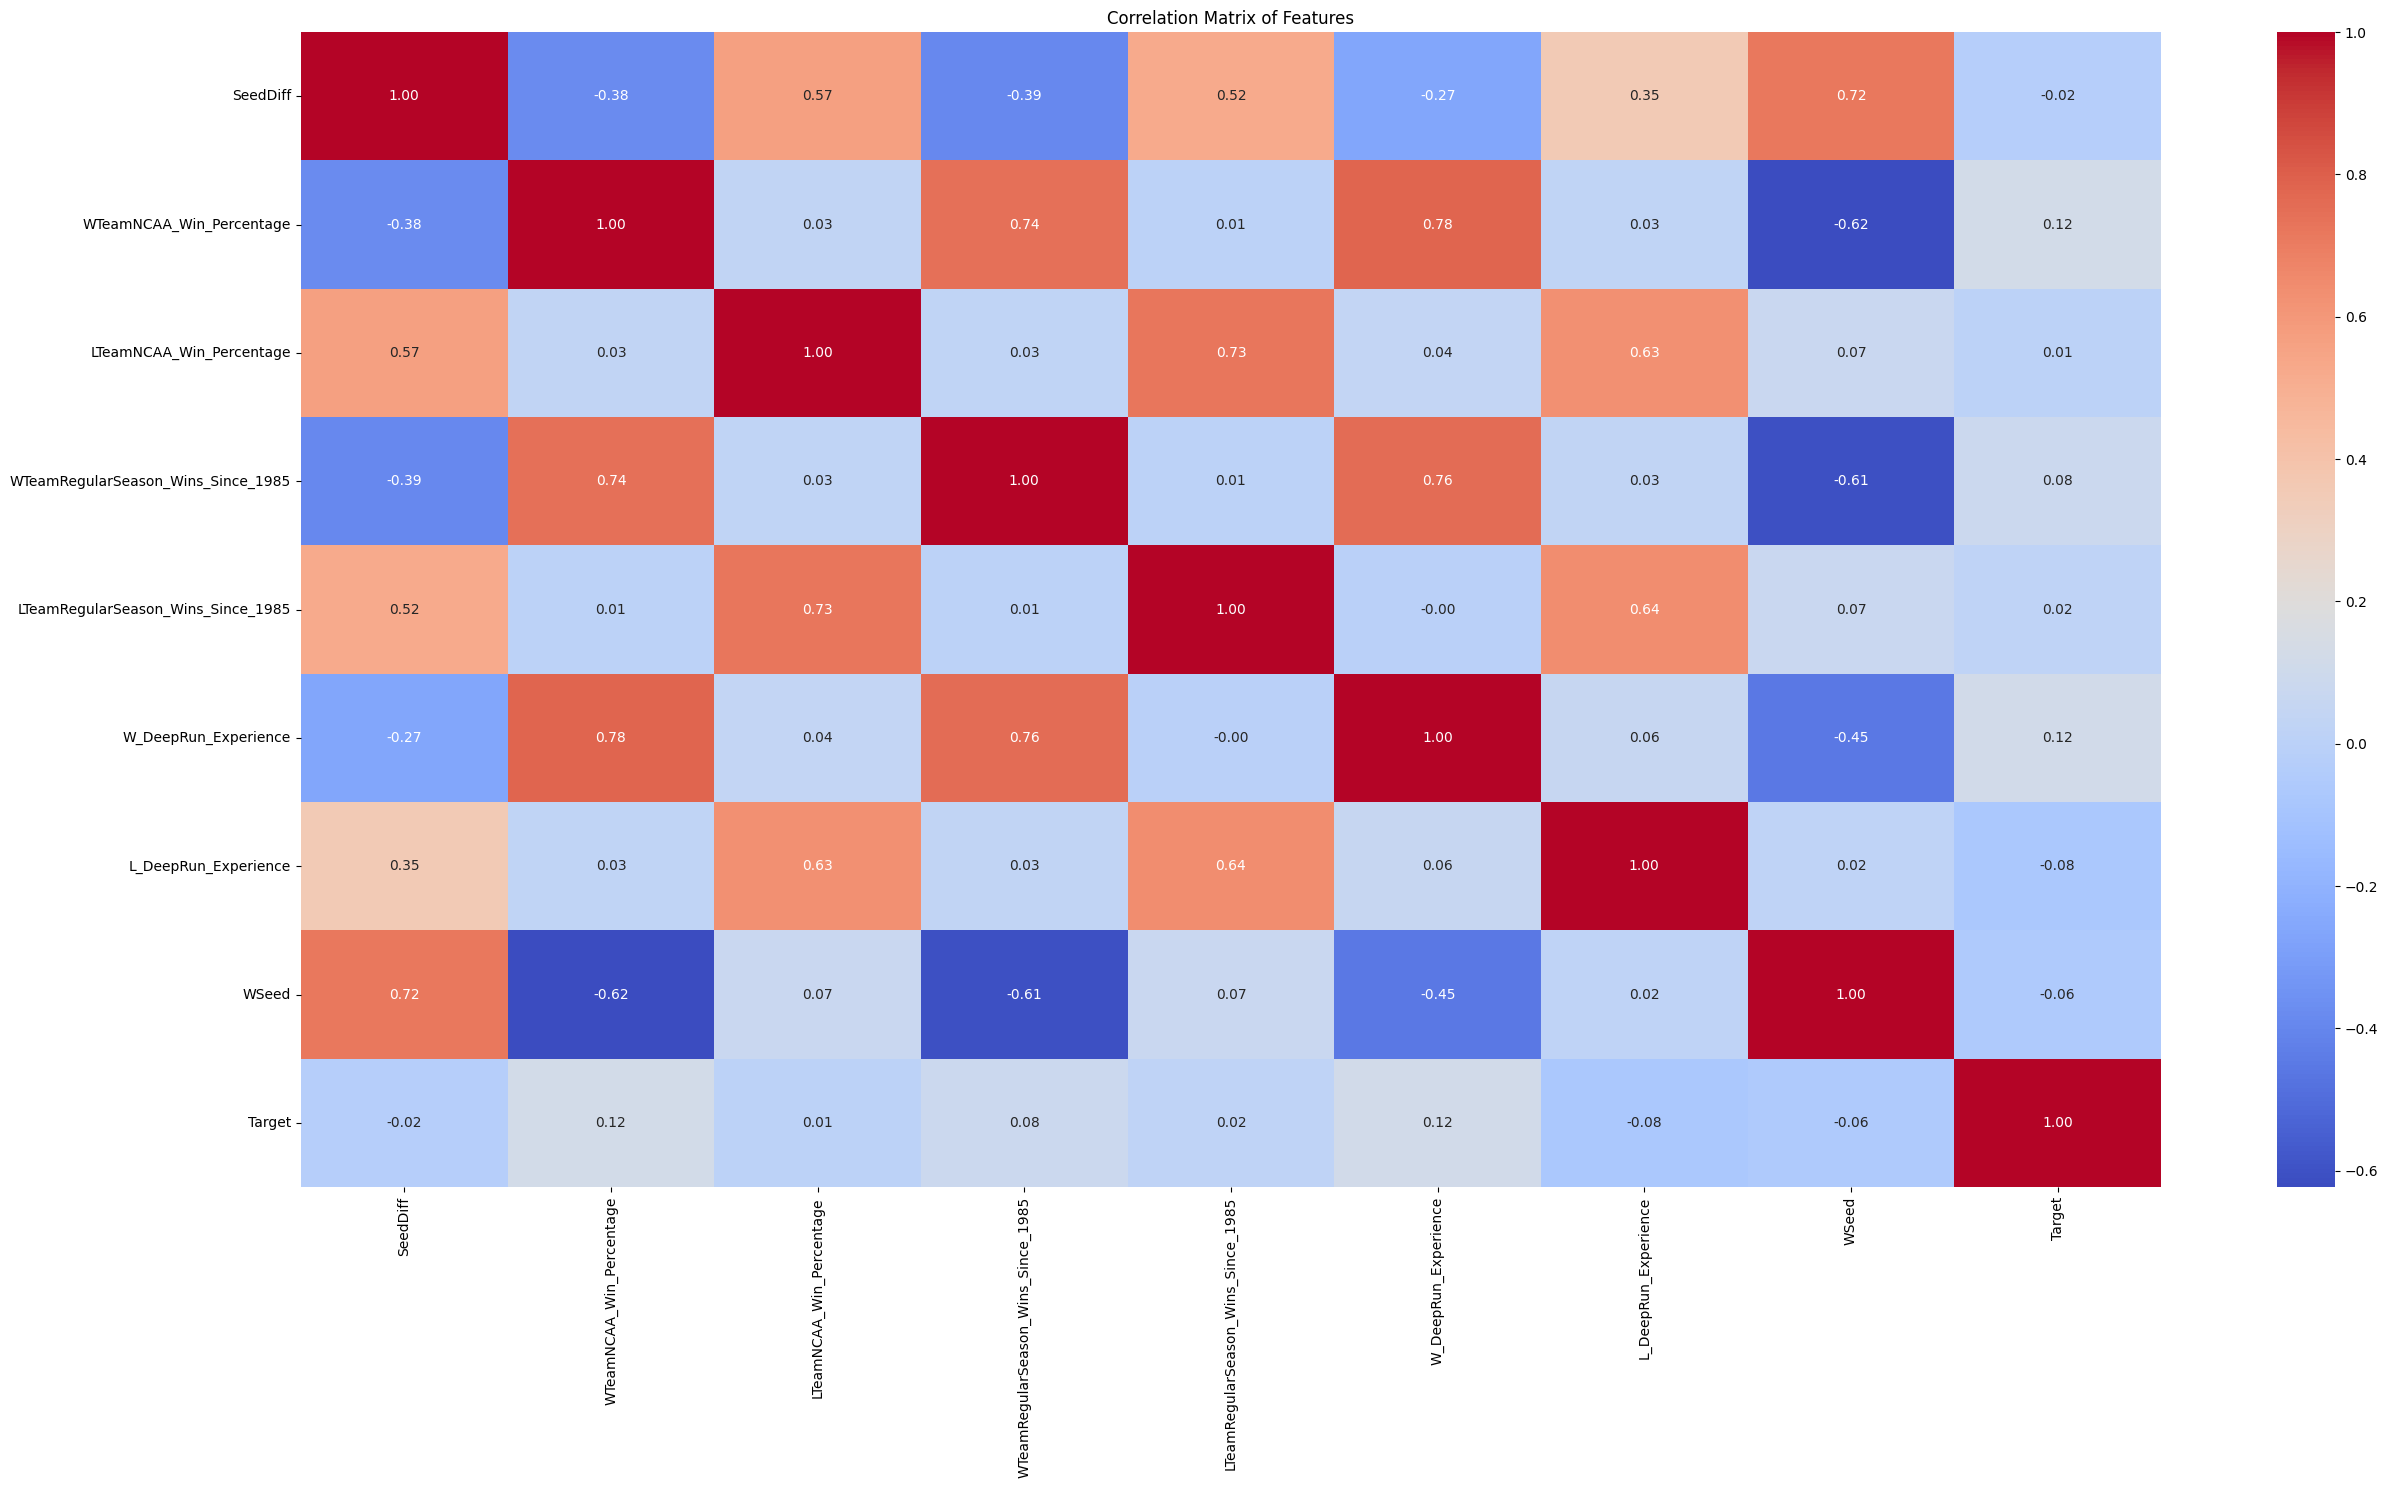

In [1847]:
# Correlation Matrix of Features
final_features = [
    'SeedDiff',
    'WTeamNCAA_Win_Percentage', 
    'LTeamNCAA_Win_Percentage',
    'WTeamRegularSeason_Wins_Since_1985', 
    'LTeamRegularSeason_Wins_Since_1985',
    'W_DeepRun_Experience', 
    'L_DeepRun_Experience',
    'WLoc', 
    'Round', 
    'WSeed',       
    'Target'        
]

# Filter the DataFrame to only include the final features
correlation_matrix_features = upset_analysis_since_2003[final_features].copy()

# Here we need to define the non numerical features
non_numerical_features = ['WLoc', 'Round']

# Here we will create a correlation matrix to see how the features are correlated with each other
correlation_matrix = correlation_matrix_features.drop(columns=non_numerical_features).corr()

# Using seaborn to create a heatmap of the correlation matrix
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

From an initial standpoint, there are some features that were correlated to each other like WTeamNCAA_Win_Percentage and W_DeepRun_Experience or WTeamRegularSeason_Wins_Since_1985 and W_DeepRun_Experience. However, even though features like this are correlated, each capture slightly different aspects of the underlying phenomenon. I found that removing them actually ended up hurting the validation accuracy. 

Furthermore, the models that I ended up using XGBoost, LightGBM, CatBoost, Random Forest, Extra Trees, and Neural Network (PyTorch) often handle correlated features pretty well. Once again, removing features did no really improve predictive power, so I ended up just keeping them. On the validation set, I observed a drop in accuracy when removing correlated features, indicating they held valuable information. The test accuracy remained stable—possibly due to sampling variance or because the test set was not large enough to reflect the difference.

# Modeling for Historical Trends

In [1848]:

# First, we will create a copy of the upset_analysis_since_2003 dataframe so that we can modify it without affecting the original data
df = upset_analysis_since_2003.copy()

# Often times in machine learning, data leakage occurs when the model is trained on data that it should not have access to. 
# Although the model may perform well on the training data, it will not generalize well to unseen data.
# To prevent data leakage, we will only use the features that are available before the game starts.
# Here we will select the feature that we want and filter upset_analysis_since_2003 to only include those features
final_features = [
    'SeedDiff',
    'WTeamNCAA_Win_Percentage', 
    'LTeamNCAA_Win_Percentage',
    'WTeamRegularSeason_Wins_Since_1985', 
    'LTeamRegularSeason_Wins_Since_1985',
    'W_DeepRun_Experience', 
    'L_DeepRun_Experience',
    'WLoc', 
    'Round', 
    'WSeed',       
    'Target'        
]

# Filter the DataFrame to only include the final features
df_final = df[final_features].copy()

# Here we split the data into training, validation, and test sets
# The initial split will be 80% training and 20% test
# We will then split the training set into 75% training and 25% validation
train_val, test = train_test_split(df_final, test_size=0.2, random_state=42, stratify=df_final['Target'])
train, val = train_test_split(train_val, test_size=0.25, random_state=42, stratify=train_val['Target'])


# We will one-hot encode the categorical columns 'WLoc' and 'Round' using the OneHotEncoder
categorical_columns = ['WLoc', 'Round']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(train[categorical_columns])  

def transform_with_encoder(df, encoder, categorical_columns, expected_columns=None):
    """
    Purpose: One-hot encode categorical columns and return transformed DataFrame
    Input: 
        - df (pd.DataFrame): DataFrame to transform
        - encoder (OneHotEncoder): Fitted OneHotEncoder
        - categorical_columns (list): List of categorical columns to encode
        - expected_columns (list): List of expected columns after encoding
    Output: df_transformed (pd.DataFrame): Transformed DataFrame
    """

    # Here we transform the categorical columns using the encoder
    encoded_array = encoder.transform(df[categorical_columns])
    # The encoder returns a NumPy array, so we convert it to a DataFrame
    encoded_df = pd.DataFrame(encoded_array, index=df.index, columns=encoder.get_feature_names_out(categorical_columns))
    
    # Drop original categorical columns
    df_transformed = df.drop(columns=categorical_columns)
    
    # Merge one-hot encoded columns
    df_transformed = pd.concat([df_transformed, encoded_df], axis=1)
    
    # If expected_columns are provided (for validation/test set), ensure they exist
    if expected_columns is not None:
        for col in expected_columns:
            if col not in df_transformed.columns:
                df_transformed[col] = 0  
    
        # Reorder columns to match training set
        df_transformed = df_transformed[expected_columns]

    return df_transformed

# We use the transform_with_encoder function to transform the training, validation, and test sets using one-hot encoding
train_encoded = transform_with_encoder(train, encoder, categorical_columns)
val_encoded = transform_with_encoder(val, encoder, categorical_columns)
test_encoded = transform_with_encoder(test, encoder, categorical_columns)

# The target variable is the 'Target' column
# The models will be saved to the 'historical_models' directory
label = "Target"
save_path = "historical_models"

# We want the best quality, which maximizes the predictive performance of the model
# We will use 5 bag folds (which is equivalent to 5-fold cross-validation)
# We will use 1 stack level to create a stack ensemble of models
# The models that we want to use are XGBoost, LightGBM, CatBoost, Random Forest, Extra Trees, and Neural Network (PyTorch)
predictor = TabularPredictor(label=label, path=save_path).fit(
    train_data=train_encoded,
    presets='best_quality',
    num_bag_folds=5,  
    num_stack_levels=1,  
    use_bag_holdout=True,  
    calibrate_decision_threshold=True,  
    hyperparameters={
        "XGB": {},
        "GBM": {},
        "CAT": {},
        "RF": {},
        "XT": {},
        "NN_TORCH": {},
    }
)

# Summary of the model
predictor.fit_summary()

# We will evaluate the model on the validation set first and leave out the test set for the final evaluation
val_performance = predictor.evaluate(val_encoded)
print("Validation set performance:")
print(val_performance)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:14:59 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T8122
CPU Count:          8
Memory Avail:       1.01 GB / 8.00 GB (12.6%)
Disk Space Avail:   13.87 GB / 228.27 GB (6.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/Users/sveerisetti/Desktop/MM_Kaggle/historical_models"
Train Data Rows:    828
Train Data Columns: 15
Label Column:       Target
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed)

	0.6807	 = Validation score   (accuracy)
	0.56s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 2392.94s of the 3593.52s of remaining time.
	0.6205	 = Validation score   (accuracy)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 2392.28s of the 3592.86s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=1, gpus=0, memory=0.52%)
	0.6928	 = Validation score   (accuracy)
	1.78s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ... Training model for up to 2386.74s of the 3587.33s of remaining time.
	0.5602	 = Validation score   (accuracy)
	0.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ... Training model for up to 2386.21s of the 3586.79s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting wi

*** Summary of fit() ***
Estimated performance of each model:
                    model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2   0.728916    accuracy       0.268847   2.847021                0.000589           0.028468            2       True          7
1     WeightedEnsemble_L3   0.728916    accuracy       0.656332  14.970052                0.000389           0.104080            3       True         14
2         CatBoost_BAG_L2   0.704819    accuracy       0.641598  14.278008                0.068695           3.509947            2       True         10
3   NeuralNetTorch_BAG_L2   0.704819    accuracy       0.796769  18.178385                0.223867           7.410324            2       True         13
4          XGBoost_BAG_L1   0.698795    accuracy       0.220532   1.040891                0.220532           1.040891            1       True          5
5         CatBoost_B

/Users/sveerisetti/Library/Python/3.9/lib/python/site-packages/autogluon/core/utils/plots.py:169: UserWarning:

AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"



Validation set performance:
{'accuracy': 0.7148014440433214, 'balanced_accuracy': 0.7147064956730267, 'mcc': 0.4300411820558694, 'roc_auc': 0.7944427067042019, 'f1': 0.7063197026022305, 'precision': 0.7251908396946565, 'recall': 0.6884057971014492}


In [1849]:
# After validiating the model on the validation set, we then evaluate on the test set
test_performance = predictor.evaluate(test_encoded)
print("Test set performance:")
print(test_performance)

Test set performance:
{'accuracy': 0.7111913357400722, 'balanced_accuracy': 0.7114702815432743, 'mcc': 0.4233822765887483, 'roc_auc': 0.7877997914494265, 'f1': 0.7163120567375887, 'precision': 0.696551724137931, 'recall': 0.7372262773722628}


### ROC Curve for Historical Model 

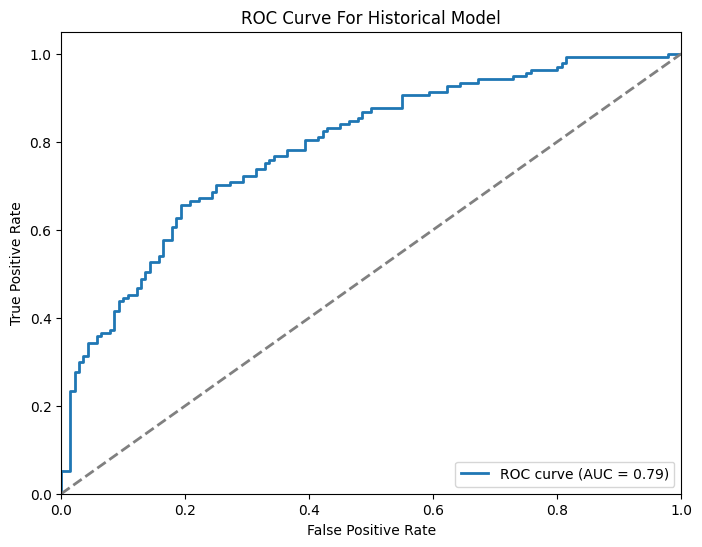

In [1850]:
# The y_true variable contains the true labels from the test set
y_true = test_encoded[label].values

# Here we get the predicted probabilities for the test set
y_proba_df = predictor.predict_proba(test_encoded)

# Here we get the probabilities for the positive class (the team with the lower TeamID)
y_proba = y_proba_df[1].values

# Here we compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# Calculate the AUC score.
roc_auc = auc(fpr, tpr)

# Plot the ROC curve.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Historical Model')
plt.legend(loc="lower right")
plt.show()

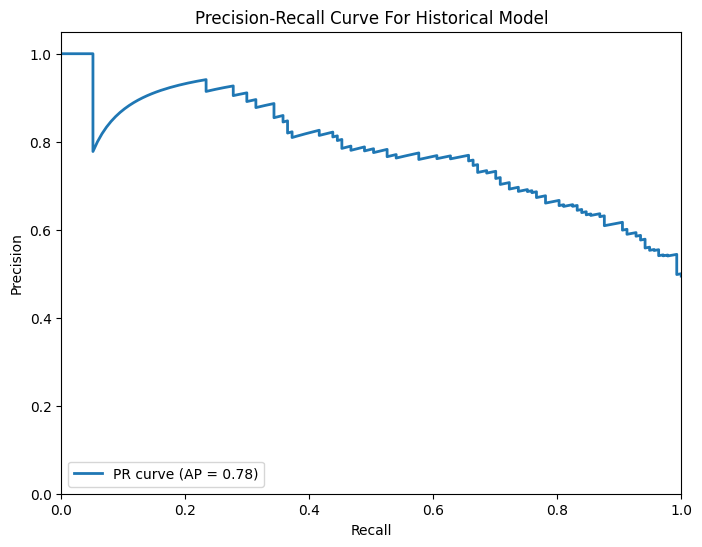

In [1851]:
# Compute precision, recall, and thresholds.
precision, recall, _ = precision_recall_curve(y_true, y_proba)

# Calculate the Average Precision (AP) score.
avg_precision = average_precision_score(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, label=f'PR curve (AP = {avg_precision:0.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve For Historical Model')
plt.legend(loc="lower left")

plt.show()

### Confusion Matrix of Historical Model Performance

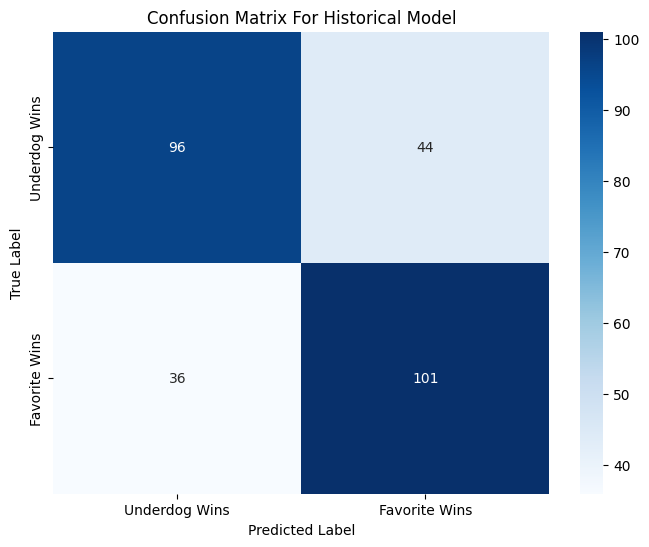

In [1852]:
# Here we generate the predictions on the test set
test_predictions = predictor.predict(test_encoded) 

# Then we create a confusion matrix
cm = confusion_matrix(test['Target'], test_predictions)

# Define class labels
labels = ["Underdog Wins", "Favorite Wins"]  

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For Historical Model")
plt.show()


Based on the Confusion Matrix: 
1. There were 164 False Negatives (FN) meaning that the model incorrectly predicted underdog wins (0), even though the favorite won (1).
2. There were 194 False Positives (FP) meaning that the model predicted that the favorite (1) would win, even though the underdog won (0) 

In [1853]:
upset_analysis_since_2003.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WSeed', 'LSeed', 'SeedDiff', 'MOV', 'WTeamName', 'LTeamName',
       'Round', 'WTeamNCAA_Wins', 'WTeamNCAA_Losses',
       'WTeamNCAA_Win_Percentage', 'LTeamNCAA_Wins', 'LTeamNCAA_Losses',
       'LTeamNCAA_Win_Percentage', 'LowerTeamID', 'HigherTeamID', 'Target',
       'WTeamRegularSeason_Wins_Since_1985',
       'WTeamRegularSeason_Losses_Since_1985',
       'LTeamRegularSeason_Wins_Since_1985',
       'LTeamRegularSeason_Losses_Since_1985', 'Sweet16_Appearance',
       'Elite8_Appearance', 'Final4_Appearance', 'Championship_Appearance',
       'W_Sweet16_Appearances', 'W_Elite8_Appearances', 'W_Final4_Appearances',
       'W_Championship_Appearances', 'L_Sweet16_Appearances',
       'L_Elite8_Appearances', 'L_Final4_Appearances',
       'L_Championship_Appearances', 'W_DeepRun_Experience',
       'L_DeepRun_Experience', 'DeepRun_Experience_Diff', 'WFGM', 'WFGA',
       'WFGM3', 'WFGA3', 'W

### Round Predictions by Historical Model 

In [1854]:
def compute_historical_team_features(df):
    """
    Purpose: Computes historical features using data from before 2025.
    Aggregates for each team:
      - TeamNCAA_Win_Percentage
      - TeamRegWinsSince1985
      - DeepRunExp
    Input: df (pd.DataFrame) - DataFrame containing historical tournament data
    Output: agg (pd.DataFrame) - DataFrame containing historical features for each team
    """

    # Here we create a copy of the dataframe that contains the data from before 2025
    df_past = df[df['Season'] < 2025].copy()
    
    # First we will focus on the winners. We will get the TeamID, TeamNCAA_Win_Percentage, TeamRegWinsSince1985, and DeepRunExp
    winners = df_past[['WTeamID', 'WTeamNCAA_Win_Percentage', 
                        'WTeamRegularSeason_Wins_Since_1985', 'W_DeepRun_Experience']].copy()
    winners = winners.rename(columns={
        'WTeamID': 'TeamID',
        'WTeamNCAA_Win_Percentage': 'TeamNCAA_Win_Percentage',
        'WTeamRegularSeason_Wins_Since_1985': 'TeamRegWinsSince1985',
        'W_DeepRun_Experience': 'DeepRunExp'
    })
    
    # Now we focus on the losers, we get the TeamID, TeamNCAA_Win_Percentage, TeamRegWinsSince1985, and DeepRunExp
    losers = df_past[['LTeamID', 'LTeamNCAA_Win_Percentage', 
                       'LTeamRegularSeason_Wins_Since_1985', 'L_DeepRun_Experience']].copy()
    losers = losers.rename(columns={
        'LTeamID': 'TeamID',
        'LTeamNCAA_Win_Percentage': 'TeamNCAA_Win_Percentage',
        'LTeamRegularSeason_Wins_Since_2000': 'TeamRegWinsSince1985',
        'L_DeepRun_Experience': 'DeepRunExp'
    })
    
    # We concatenate the winners and losers dataframes and then group by TeamID to get the mean of each feature
    combined = pd.concat([winners, losers], ignore_index=True)
    agg = combined.groupby('TeamID', as_index=False).agg({
        'TeamNCAA_Win_Percentage': 'mean',
        'TeamRegWinsSince1985': 'mean',
        'DeepRunExp': 'mean'
    })
    return agg

def seed_to_int(seed):
    """
    Purpose: Converts a seed string to an integer.
    Input: seed (str) - Seed string (e.g., 'W01')
    Output: seed_int (int) - Seed integer (e.g., 1)
    """
    try:
        # The seed string may contain non-numeric characters, so we extract the digits
        seed_str = str(seed)
        num = ''.join(filter(str.isdigit, seed_str))
        return int(num) if num else None
    except Exception as e:
        print(f"DEBUG: Could not convert seed {seed} to int: {e}")
        return None

def build_matchup_row_historical(team_lower, team_higher, hist_features_df, seeds_df_2025):
    """
    Purpose: Builds a matchup row for the historical model for season 2025.
    - Looks up historical features and seed info.
    - Computes seed difference and maps the lower seed team to the W_ columns,
      and the higher seed team to the L_ columns.
    Input: 
    - team_lower (int) - TeamID of lower seed team
    - team_higher (int) - TeamID of higher seed team
    - hist_features_df (pd.DataFrame) - Historical features for each team
    - seeds_df_2025 (pd.DataFrame) - Seeds for 2025
    Output: matchup_row (pd.DataFrame) - DataFrame with matchup features
    """
    # Here we extract the row for the lower and higher seed teams
    lower_row = hist_features_df[hist_features_df['TeamID'] == team_lower]
    higher_row = hist_features_df[hist_features_df['TeamID'] == team_higher]

    # If the lower or higher seed team is missing historical features, we return None
    if lower_row.empty or higher_row.empty:
        print(f"DEBUG: Missing historical features for {team_lower} or {team_higher}")
        return None
    
    # We use iloc to use index 0 to get the first row
    lr = lower_row.iloc[0]
    hr = higher_row.iloc[0]
    
    # Now we get the seed info for the lower and higher seed teams
    lower_seed_row = seeds_df_2025[seeds_df_2025['TeamID'] == team_lower]
    higher_seed_row = seeds_df_2025[seeds_df_2025['TeamID'] == team_higher]
    if lower_seed_row.empty or higher_seed_row.empty:
        print(f"DEBUG: Missing seed info for {team_lower} or {team_higher}")
        return None
    
    # Similar to the historical features, we use iloc to get the first row
    lower_seed = lower_seed_row.iloc[0]['Seed']
    higher_seed = higher_seed_row.iloc[0]['Seed']

    # We convert the seed strings to integers using the seed_to_int function
    lower_seed_int = seed_to_int(lower_seed)
    higher_seed_int = seed_to_int(higher_seed)
    if lower_seed_int is None or higher_seed_int is None:
        print(f"DEBUG: Could not parse seeds: {lower_seed}, {higher_seed}")
        return None
    
    # The seed difference is a key feature in our algorithm
    seed_diff = lower_seed_int - higher_seed_int

    # Dictionary that contains the matchup features
    matchup_dict = {
        'SeedDiff': seed_diff,
        'WSeed': str(lower_seed_int),
        'WTeamNCAA_Win_Percentage': lr['TeamNCAA_Win_Percentage'],
        'WTeamRegularSeason_Wins_Since_1985': lr['TeamRegWinsSince1985'],
        'W_DeepRun_Experience': lr['DeepRunExp'],
        'LTeamNCAA_Win_Percentage': hr['TeamNCAA_Win_Percentage'],
        'LTeamRegularSeason_Wins_Since_1985': hr['TeamRegWinsSince1985'],
        'L_DeepRun_Experience': hr['DeepRunExp'],
        'WLoc': 'N',  # This will always be neutral because in the NCAA tournament, games are played on neutral courts
        'Round': 'Round 1 (64 Teams)',  # Default round, we will update this later
        'weight': 1
    }
    return pd.DataFrame([matchup_dict])

def lookup_team_id(team_name, mteams_df):
    """
    Purpose: Looks up the TeamID and matched TeamName from mteams_df based on team_name.
    Handles exact and partial (case-insensitive) matches.
    Raises ValueError if no match is found.
    Input: 
    - team_name (str) - Team name to look up
    - mteams_df (pd.DataFrame) - DataFrame containing TeamID and TeamName
    Output:
    - team_id (int) - TeamID
    - matched_name (str) - Matched TeamName
    """

    # Here we look for an exact match of the team name
    matches = mteams_df[mteams_df['TeamName'].str.lower() == team_name.lower()]
    # If the match is empty then we look for a partial match
    # If the partial match is empty then we raise a ValueError
    if matches.empty:
        # Use str.contains to find partial matches
        partial = mteams_df[mteams_df['TeamName'].str.contains(team_name, case=False, na=False)]
        if partial.empty:
            raise ValueError(f"DEBUG: Team '{team_name}' not found in mteams_df (no partial match).")
        else:
            # We print the partial match
            print(f"DEBUG: Team '{team_name}' not found by exact match. Using partial match: {list(partial['TeamName'])}")
            matches = partial
    if len(matches) > 1:
        print(f"DEBUG: Multiple matches for '{team_name}': {list(matches['TeamName'])}. Using the first.")
    row = matches.iloc[0]
    return int(row['TeamID']), row['TeamName']

def process_historical_matchups(round_name, matchups_info, hist_features_df, mteams, seeds_df_2025, encoder, predictor):
    """
    Purpose: Processes a round of historical matchups.
    For each matchup:
      - Uses lookup_team_id to get team IDs.
      - Determines the lower (better) and higher seed teams.
      - Calls build_matchup_row_historical to build a row.
      - Encodes categorical columns and predicts the probability.
    Input: 
    - round_name (str) - Name of the round (e.g., "Round 1")
    - matchups_info (list) - List of matchup dictionaries with keys: Region, Team1, Team2
    - hist_features_df (pd.DataFrame) - DataFrame with historical team features.
    - mteams (pd.DataFrame) - DataFrame with TeamID and TeamName.
    - seeds_df_2025 (pd.DataFrame) - DataFrame with TeamID and Seed for 2025.
    - encoder (OneHotEncoder) - Fitted OneHotEncoder for categorical columns.
    - predictor (TabularPredictor) - Trained historical model.
    Returns:
      - all_matchups_df: DataFrame with all matchup features.
      - final_submission: DataFrame with columns [ID, Region, LowerTeamName, HigherTeamName, Pred].
    """

    # Empty list to store matchup rows
    matchup_list = []

    # For each match in the matchups_info list of dictionaries, we will process the matchup
    for m in matchups_info:
        region = m['Region']
        t1_name = m['Team1']
        t2_name = m['Team2']
        try:
            # We use the lookup_team_id function to get the TeamID and matched TeamName
            team1_id, team1_matched = lookup_team_id(t1_name, mteams)
            team2_id, team2_matched = lookup_team_id(t2_name, mteams)
        except ValueError as e:
            print(e)
            continue

        # We will get the seed info for the lower and higher seed teams
        t1_seed_row = seeds_df_2025[seeds_df_2025['TeamID'] == team1_id]
        t2_seed_row = seeds_df_2025[seeds_df_2025['TeamID'] == team2_id]
        if t1_seed_row.empty or t2_seed_row.empty:
            print(f"DEBUG: Missing seed info for TeamID {team1_id} or {team2_id}")
            continue

        # We convert the seed strings to integers using the seed_to_int function
        team1_seed_int = seed_to_int(t1_seed_row.iloc[0]['Seed'])
        team2_seed_int = seed_to_int(t2_seed_row.iloc[0]['Seed'])
        if team1_seed_int is None or team2_seed_int is None:
            print(f"DEBUG: Could not parse seeds for {t1_name} or {t2_name}")
            continue

        # The lower seed is the better seed on paper. Here we determine the lower and higher seed teams
        if team1_seed_int < team2_seed_int:
            lower_id, lower_name = team1_id, team1_matched
            higher_id, higher_name = team2_id, team2_matched
        else:
            lower_id, lower_name = team2_id, team2_matched
            higher_id, higher_name = team1_id, team1_matched

        # We use the build_matchup_row_historical function to build a matchup row
        row_df = build_matchup_row_historical(lower_id, higher_id, hist_features_df, seeds_df_2025)
        if row_df is None:
            print(f"DEBUG: Could not build matchup row for {lower_name} vs. {higher_name}.")
            continue

        # Additional columns that we can update if needed
        row_df['Region'] = region
        row_df['LowerTeamName'] = lower_name
        row_df['HigherTeamName'] = higher_name
        row_df['ID'] = f"hist_{lower_id}_{higher_id}"

        matchup_list.append(row_df)
    
    # If there is a matchup list, we concatenate the rows to create a DataFrame
    if matchup_list:
        all_matchups_df = pd.concat(matchup_list, ignore_index=True)
    else:
        all_matchups_df = pd.DataFrame()
    
    print(f"DEBUG ({round_name}): Built {len(all_matchups_df)} matchup rows from {len(matchups_info)} requested games.")
    
    # If there are no matchups to predict, we return None
    # This is mainly for the case where there are no historical matchups to predict
    if all_matchups_df.empty:
        print(f"{round_name}: No historical matchups to predict.")
        return all_matchups_df, None

    categorical_columns = ['WLoc', 'Round']
    all_matchups_encoded = transform_with_encoder(all_matchups_df, encoder, categorical_columns)
    predicted_probs = predictor.predict_proba(all_matchups_encoded)
    all_matchups_df['Pred'] = predicted_probs[1]
    final_submission = all_matchups_df[['ID', 'Region', 'LowerTeamName', 'HigherTeamName', 'Pred']].copy()
    return all_matchups_df, final_submission

In [1855]:

# Here we define the historical matchup rounds via the matchups_info dictionary
# We use compute_historical_team_features to get the historical team features
historical_team_features = compute_historical_team_features(upset_analysis_since_2003)
print("DEBUG: Historical team features:")
display(historical_team_features.head())

# Here we load in the bets model from the historical_models directory
predictor = TabularPredictor.load("historical_models")

# Define historical matchup rounds including Round1, Round2, Sweet16, Elite8, Final4, and Championship
historical_rounds = {
        "Round 1": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Alabama St'},  
        {'Region': 'South', 'Team1': 'Louisville', 'Team2': 'Creighton'},
        {'Region': 'South', 'Team1': 'Michigan', 'Team2': 'UC San Diego'},
        {'Region': 'South', 'Team1': 'Texas A&M', 'Team2': 'Yale'},
        {'Region': 'South', 'Team1': 'Mississippi', 'Team2': 'North Carolina'},  
        {'Region': 'South', 'Team1': 'Iowa St', 'Team2': 'Lipscomb'},
        {'Region': 'South', 'Team1': 'Marquette', 'Team2': 'New Mexico'},
        {'Region': 'South', 'Team1': 'Michigan St', 'Team2': 'Bryant'},
        {'Region': 'East', 'Team1': 'Duke', 'Team2': "Mt St Mary's"},
        {'Region': 'East', 'Team1': 'Mississippi St', 'Team2': 'Baylor'},
        {'Region': 'East', 'Team1': 'Oregon', 'Team2': 'Liberty'},
        {'Region': 'East', 'Team1': 'Arizona', 'Team2': 'Akron'},
        {'Region': 'East', 'Team1': 'BYU', 'Team2': 'VCU'},
        {'Region': 'East', 'Team1': 'Wisconsin', 'Team2': 'Montana'},
        {'Region': 'East', 'Team1': "St Mary's CA", 'Team2': 'Vanderbilt'},
        {'Region': 'East', 'Team1': 'Alabama', 'Team2': 'Robert Morris'},
        {'Region': 'Midwest', 'Team1': 'Houston', 'Team2': 'SIUE'},
        {'Region': 'Midwest', 'Team1': 'Gonzaga', 'Team2': 'Georgia'},
        {'Region': 'Midwest', 'Team1': 'Clemson', 'Team2': 'McNeese St'},
        {'Region': 'Midwest', 'Team1': 'Purdue', 'Team2': 'High Point'},
        {'Region': 'Midwest', 'Team1': 'Illinois', 'Team2': 'Texas'},  
        {'Region': 'Midwest', 'Team1': 'Kentucky', 'Team2': 'Troy'},
        {'Region': 'Midwest', 'Team1': 'UCLA', 'Team2': 'Utah St'},
        {'Region': 'Midwest', 'Team1': 'Tennessee', 'Team2': 'Wofford'},
        {'Region': 'West', 'Team1': 'Florida', 'Team2': 'Norfolk St'},
        {'Region': 'West', 'Team1': 'Connecticut', 'Team2': 'Oklahoma'},
        {'Region': 'West', 'Team1': 'Memphis', 'Team2': 'Colorado St'},
        {'Region': 'West', 'Team1': 'Maryland', 'Team2': 'Grand Canyon'},
        {'Region': 'West', 'Team1': 'Missouri', 'Team2': 'Drake'},
        {'Region': 'West', 'Team1': 'Texas Tech', 'Team2': 'UNC Wilmington'},
        {'Region': 'West', 'Team1': 'Kansas', 'Team2': 'Arkansas'},
        {'Region': 'West', 'Team1': "St John's", 'Team2': 'Omaha'},
    ],
    "Round 2": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Louisville'}, 
        {'Region': 'South', 'Team1': 'Texas A&M', 'Team2': 'Michigan'},
        {'Region': 'South', 'Team1': 'North Carolina', 'Team2': 'Lipscomb'},  
        {'Region': 'South', 'Team1': 'Marquette', 'Team2': 'Bryant'},
        {'Region': 'East', 'Team1': 'Duke', 'Team2': "Baylor"},
        {'Region': 'East', 'Team1': 'Arizona', 'Team2': 'Oregon'},
        {'Region': 'East', 'Team1': 'Wisconsin', 'Team2': 'BYU'},
        {'Region': 'East', 'Team1': 'Alabama', 'Team2': "St Mary's CA"},
        {'Region': 'Midwest', 'Team1': 'Houston', 'Team2': 'Gonzaga'},
        {'Region': 'Midwest', 'Team1': 'Purdue', 'Team2': 'McNeese St'}, 
        {'Region': 'Midwest', 'Team1': 'Kentucky', 'Team2': 'Illinois'},
        {'Region': 'Midwest', 'Team1': 'Tennessee', 'Team2': 'UCLA'},
        {'Region': 'West', 'Team1': 'Florida', 'Team2': 'Connecticut'},
        {'Region': 'West', 'Team1': 'Maryland', 'Team2': 'Colorado St'},
        {'Region': 'West', 'Team1': 'Texas Tech', 'Team2': 'Drake'},
        {'Region': 'West', 'Team1': "St John's", 'Team2': 'Arkansas'},
    ],
    "Sweet 16": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Texas A&M'}, 
        {'Region': 'South', 'Team1': 'North Carolina', 'Team2': 'Bryant'},
        {'Region': 'East', 'Team1': 'Duke', 'Team2': 'Arizona'},
        {'Region': 'East', 'Team1': 'Alabama', 'Team2': 'BYU'},
        {'Region': 'Midwest', 'Team1': 'Gonzaga', 'Team2': 'McNeese St'}, 
        {'Region': 'Midwest', 'Team1': 'Tennessee', 'Team2': 'Kentucky'},
        {'Region': 'West', 'Team1': 'Florida', 'Team2': 'Maryland'},
        {'Region': 'West', 'Team1': 'Arkansas', 'Team2': 'Drake'},
    ],
    "Elite 8": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Bryant'}, 
        {'Region': 'East', 'Team1': 'Duke', 'Team2': 'Alabama'},
        {'Region': 'Midwest', 'Team1': 'Gonzaga', 'Team2': 'Kentucky'}, 
        {'Region': 'West', 'Team1': 'Florida', 'Team2': 'Drake'},
    ],
    "Final 4": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Florida'}, 
        {'Region': 'East', 'Team1': 'Alabama', 'Team2': 'Gonzaga'},
    ],
    "Final Round": [
        {'Region': 'South', 'Team1': 'Florida', 'Team2': 'Alabama'}, 
    ]
}

# We will process the historical matchups for each round
# The final_hist_tables dictionary will store the final submission for each round
final_hist_tables = {}
# For each round name, matchups_info in historical_rounds list of dictionaries, we will process the historical matchups
for round_name, matchups_info in historical_rounds.items(): 
    _, final_submission = process_historical_matchups(
        round_name,
        matchups_info,
        historical_team_features,
        mteams,
        men_tournament_seeds_2025,
        encoder,
        predictor
    )
    if final_submission is not None:
        print(f"\n{round_name} Historical Submission:")
        display(final_submission)
        final_hist_tables[round_name] = final_submission

DEBUG: Historical team features:


,TeamID,TeamNCAA_Win_Percentage,TeamRegWinsSince1985,DeepRunExp
0,1101,0.333333,152.0,0.0
1,1102,0.000000,NaN,0.0
2,1103,0.000000,NaN,0.0
3,1104,0.574468,799.0,4.0
4,1105,0.000000,NaN,0.0


DEBUG: Missing historical features for 1276 or 1471
DEBUG: Could not build matchup row for Michigan vs. UC San Diego.
DEBUG: Missing historical features for 1222 or 1188
DEBUG: Could not build matchup row for Houston vs. SIUE.
DEBUG: Missing historical features for 1345 or 1219
DEBUG: Could not build matchup row for Purdue vs. High Point.
DEBUG: Team 'Omaha' not found by exact match. Using partial match: ['NE Omaha']
DEBUG: Missing historical features for 1385 or 1303
DEBUG: Could not build matchup row for St John's vs. NE Omaha.
DEBUG (Round 1): Built 28 matchup rows from 32 requested games.

Round 1 Historical Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,hist_1120_1106,South,Auburn,Alabama St,0.651131
1,hist_1257_1166,South,Louisville,Creighton,0.469908
2,hist_1401_1463,South,Texas A&M,Yale,0.551375
3,hist_1279_1314,South,Mississippi,North Carolina,0.289181
4,hist_1235_1252,South,Iowa St,Lipscomb,0.285974
5,hist_1266_1307,South,Marquette,New Mexico,0.615553
6,hist_1277_1136,South,Michigan St,Bryant,0.274734
7,hist_1181_1291,East,Duke,Mt St Mary's,0.381950
8,hist_1280_1124,East,Mississippi St,Baylor,0.172118
9,hist_1332_1251,East,Oregon,Liberty,0.532713


DEBUG (Round 2): Built 16 matchup rows from 16 requested games.

Round 2 Historical Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,hist_1120_1257,South,Auburn,Louisville,0.717412
1,hist_1401_1276,South,Texas A&M,Michigan,0.198171
2,hist_1314_1252,South,North Carolina,Lipscomb,0.422731
3,hist_1266_1136,South,Marquette,Bryant,0.210145
4,hist_1181_1124,East,Duke,Baylor,0.322228
5,hist_1112_1332,East,Arizona,Oregon,0.551260
6,hist_1458_1140,East,Wisconsin,BYU,0.235890
7,hist_1104_1388,East,Alabama,St Mary's CA,0.760066
8,hist_1222_1211,Midwest,Houston,Gonzaga,0.720755
9,hist_1345_1270,Midwest,Purdue,McNeese St,0.277064


DEBUG (Sweet 16): Built 8 matchup rows from 8 requested games.



Sweet 16 Historical Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,hist_1120_1401,South,Auburn,Texas A&M,0.785985
1,hist_1314_1136,South,North Carolina,Bryant,0.429428
2,hist_1181_1112,East,Duke,Arizona,0.509685
3,hist_1104_1140,East,Alabama,BYU,0.573031
4,hist_1211_1270,Midwest,Gonzaga,McNeese St,0.572750
5,hist_1397_1246,Midwest,Tennessee,Kentucky,0.211418
6,hist_1196_1268,West,Florida,Maryland,0.754548
7,hist_1116_1179,West,Arkansas,Drake,0.627782


DEBUG (Elite 8): Built 4 matchup rows from 4 requested games.

Elite 8 Historical Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,hist_1120_1136,South,Auburn,Bryant,0.651131
1,hist_1181_1104,East,Duke,Alabama,0.682952
2,hist_1246_1211,Midwest,Kentucky,Gonzaga,0.732813
3,hist_1196_1179,West,Florida,Drake,0.661763


DEBUG (Final 4): Built 2 matchup rows from 2 requested games.

Final 4 Historical Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,hist_1196_1120,South,Florida,Auburn,0.407184
1,hist_1104_1211,East,Alabama,Gonzaga,0.601301


DEBUG (Final Round): Built 1 matchup rows from 1 requested games.

Final Round Historical Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,hist_1196_1104,South,Florida,Alabama,0.60477


# Data Manipulation for 2024 - 2025 Regular Season Model 

In [1856]:
# We only want to focus our attention to the games in the 2024-2025 seasons
season_2024_2025 = men_regular_season_detailed_game_results[
    (men_regular_season_detailed_game_results['Season'] >= 2024) & 
    (men_regular_season_detailed_game_results['Season'] <= 2025)
].copy()

# Here we create a dataframe for the wins and losses
# We will use this dataframe to calculate the margin of victory for each game
# This will help us understand how dominant a team was in a particular game
wins = season_2024_2025[['Season', 'DayNum', 'WTeamID', 'WScore', 'LScore']].copy()
wins['Win'] = 1
wins['TeamID'] = wins['WTeamID']
wins = wins.rename(columns={'WScore': 'PointsFor', 'LScore': 'PointsAgainst'})

# Here we create a dataframe for the losses
losses = season_2024_2025[['Season', 'DayNum', 'LTeamID', 'LScore', 'WScore']].copy()
losses['Win'] = 0
losses['TeamID'] = losses['LTeamID']
losses = losses.rename(columns={'LScore': 'PointsFor', 'WScore': 'PointsAgainst'})

# We combine the wins and losses dataframes
team_games = pd.concat([wins, losses], ignore_index=True)

# Calculate margin of victory for each game
team_games['MOV'] = team_games['PointsFor'] - team_games['PointsAgainst']
team_games.head()


,Season,DayNum,WTeamID,PointsFor,PointsAgainst,Win,TeamID,LTeamID,MOV
0,2024,0,1101.0,64,59,1,1101,NaN,5
1,2024,0,1103.0,81,75,1,1103,NaN,6
2,2024,0,1104.0,105,73,1,1104,NaN,32
3,2024,0,1112.0,122,59,1,1112,NaN,63
4,2024,0,1114.0,71,66,1,1114,NaN,5


In [1857]:
# Now we want to calculate the season-level stats for each team
# We will calculate the total number of games played, wins, win percentage, average points for, average points against, and average margin of victory
season_stats = team_games.groupby(['Season', 'TeamID']).agg(
    TotalGames=('Win', 'count'),
    Wins=('Win', 'sum'),
    Avg_PointsFor=('PointsFor', 'mean'),
    Avg_PointsAgainst=('PointsAgainst', 'mean'),
    Avg_MOV=('MOV', 'mean')
).reset_index()

# The win percetange is the number of wins divided by the total number of games played
season_stats['Win_Percentage'] = season_stats['Wins'] / season_stats['TotalGames']

# Quick look at the season stats
print(season_stats.head())

# We want to sort the team_games dataframe by TeamID and DayNum
# This will help us calculate the last 10 game stats for each team
team_games = team_games.sort_values(by=["TeamID", "DayNum"])


def compute_last10_stats(df, window=10):
    """
    Purpose: Compute last 10 game stats for each team in the DataFrame.
    Input:
    - df (pd.DataFrame): DataFrame with TeamID, Win, PointsFor, PointsAgainst, MOV columns
    - window (int): Number of games to consider for last 10 game stats
    Output: df (pd.DataFrame): DataFrame with Last10_WinPct, Last10_PPG, Last10_OppPPG, Last10_MOV columns
    """
    df['Last10_WinPct'] = df.groupby("TeamID")["Win"].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df['Last10_PPG'] = df.groupby("TeamID")["PointsFor"].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df['Last10_OppPPG'] = df.groupby("TeamID")["PointsAgainst"].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df['Last10_MOV'] = df['Last10_PPG'] - df['Last10_OppPPG']
    return df

# We use the compute_last10_stats function to calculate the last 10 game stats for each team
team_games = compute_last10_stats(team_games, window=10)

# For each team, we take the last row of the last 10 game stats to get the most recent stats
last10_stats = team_games.groupby(['Season', 'TeamID']).apply(lambda x: x.sort_values("DayNum").iloc[-1]).reset_index(drop=True)
last10_features = last10_stats[['Season', 'TeamID', 'Last10_WinPct', 'Last10_PPG', 'Last10_OppPPG', 'Last10_MOV']]


   Season  TeamID  TotalGames  Wins  Avg_PointsFor  Avg_PointsAgainst  \
0    2024    1101          31    14      70.967742          73.612903   
1    2024    1102          31     9      66.161290          72.354839   
2    2024    1103          32    22      72.343750          66.812500   
3    2024    1104          32    21      90.750000          81.062500   
4    2024    1105          33    11      68.696970          75.787879   

    Avg_MOV  Win_Percentage  
0 -2.645161        0.451613  
1 -6.193548        0.290323  
2  5.531250        0.687500  
3  9.687500        0.656250  
4 -7.090909        0.333333  


/var/folders/85/1l0v0zxd5q31ry0x76fqfv0c0000gn/T/ipykernel_51361/1648127832.py:40: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [1858]:
# For demonstration, assume tournament_data_2024_2025 is your matchup-level DataFrame for the tournament
# It should contain Season, WTeamID, LTeamID, etc.
tournament_data_2024_2025 = season_2024_2025.copy()  

# This will get us the winning team's season-level aggregates
# We add the prefix "W_" to the columns to indicate they are for the winning team
season_stats_w = season_stats.copy().add_prefix("W_")
tournament_data_2024_2025 = tournament_data_2024_2025.merge(
    season_stats_w,
    left_on=["Season", "WTeamID"],
    right_on=["W_Season", "W_TeamID"],
    how="left"
)

# This will add the losing team's season-level aggregates
# We add the prefix "L_" to the columns to indicate they are for the losing team
season_stats_l = season_stats.copy().add_prefix("L_")
tournament_data_2024_2025 = tournament_data_2024_2025.merge(
    season_stats_l,
    left_on=["Season", "LTeamID"],
    right_on=["L_Season", "L_TeamID"],
    how="left"
)

# Here we add the last 10 game features for the winners to get form 
# We add the prefix "W_last10_" to the columns to indicate they are for the winning team
last10_w = last10_features.copy().add_prefix("W_last10_")
tournament_data_2024_2025 = tournament_data_2024_2025.merge(
    last10_w,
    left_on=["Season", "WTeamID"],
    right_on=["W_last10_Season", "W_last10_TeamID"],
    how="left"
)

# Here we add the last 10 game features for the losers to get form
# We add the prefix "L_last10_" to the columns to indicate they are for the losing team
last10_l = last10_features.copy().add_prefix("L_last10_")
tournament_data_2024_2025 = tournament_data_2024_2025.merge(
    last10_l,
    left_on=["Season", "LTeamID"],
    right_on=["L_last10_Season", "L_last10_TeamID"],
    how="left"
)

# We add a feature called "CurrentForm_Flag" to indicate that we have added the current form features
tournament_data_2024_2025["CurrentForm_Flag"] = 1

# Now, tournament_data_2024_2025 will include both your original game-level features (like DayNum, MOV, SeedDiff, etc.)
# and the newly merged current form features from season_stats and last10_features.
tournament_data_2024_2025.columns


Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'W_Season', 'W_TeamID', 'W_TotalGames', 'W_Wins', 'W_Avg_PointsFor',
       'W_Avg_PointsAgainst', 'W_Avg_MOV', 'W_Win_Percentage', 'L_Season',
       'L_TeamID', 'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor',
       'L_Avg_PointsAgainst', 'L_Avg_MOV', 'L_Win_Percentage',
       'W_last10_Season', 'W_last10_TeamID', 'W_last10_Last10_WinPct',
       'W_last10_Last10_PPG', 'W_last10_Last10_OppPPG', 'W_last10_Last10_MOV',
       'L_last10_Season', 'L_last10_TeamID', 'L_last10_Last10_WinPct',
       'L_last10_Last10_PPG', 'L_last10_Last10_OppPPG', 'L_last10_Last10_MOV',
       'CurrentForm_Flag'],
      dtype='object')

In [1859]:
tournament_data_2024_2025

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,W_last10_Last10_PPG,W_last10_Last10_OppPPG,W_last10_Last10_MOV,L_last10_Season,L_last10_TeamID,L_last10_Last10_WinPct,L_last10_Last10_PPG,L_last10_Last10_OppPPG,L_last10_Last10_MOV,CurrentForm_Flag
0,2024,0,1101,64,1329,59,A,0,26,57,...,69.5,69.2,0.3,2024.0,1329.0,0.2,67.4,78.0,-10.6,1
1,2024,0,1103,81,1355,75,A,0,26,57,...,80.6,72.4,8.2,2024.0,1355.0,0.8,71.9,67.2,4.7,1
2,2024,0,1104,105,1287,73,H,0,32,57,...,91.7,87.6,4.1,2024.0,1287.0,0.6,67.3,62.6,4.7,1
3,2024,0,1112,122,1288,59,H,0,42,76,...,81.5,76.6,4.9,2024.0,1288.0,0.5,76.2,76.8,-0.6,1
4,2024,0,1114,71,1402,66,H,0,22,59,...,72.6,66.2,6.4,2024.0,1402.0,0.7,78.9,74.0,4.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11243,2025,132,1196,86,1397,77,N,0,26,61,...,93.9,82.9,11.0,2025.0,1397.0,0.6,74.4,73.3,1.1,1
11244,2025,132,1272,84,1412,72,N,0,32,68,...,82.9,75.6,7.3,2025.0,1412.0,0.8,81.3,73.6,7.7,1
11245,2025,132,1276,59,1458,53,N,0,19,59,...,66.6,76.1,-9.5,2025.0,1458.0,0.6,75.1,71.5,3.6,1
11246,2025,132,1433,68,1206,63,N,0,19,47,...,70.6,65.9,4.7,2025.0,1206.0,0.6,65.9,62.4,3.5,1


In [1860]:
def create_and_filter_features(df):
    """
    Purpose: Create aggregated features and filter columns to avoid data leakage.
    Input: df (pd.DataFrame): DataFrame with original features
    Output: df_final (pd.DataFrame): DataFrame with final features for modeling
    """

    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()  
    
    # We want to create aggregated features for the winners and losers so that we can use them as features for our model
    # Compute point differentials for season-level and last-10 games metrics
    df['W_PointDiff'] = df['W_Avg_PointsFor'] - df['W_Avg_PointsAgainst']
    df['L_PointDiff'] = df['L_Avg_PointsFor'] - df['L_Avg_PointsAgainst']
    df['W_Last10_PointDiff'] = df['W_last10_Last10_PPG'] - df['W_last10_Last10_OppPPG']
    df['L_Last10_PointDiff'] = df['L_last10_Last10_PPG'] - df['L_last10_Last10_OppPPG']
    
    # These are the features that we need to get rid of. Logically speaking, we will not have access to these features before the game starts
    # which is why we need to get rid of them
    leakage_columns = [
        'WScore', 'LScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA',
        'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
        'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
        'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'NumOT'
    ]
    df_filtered = df.drop(columns=leakage_columns, errors='ignore')

    # These are the final features that we want to keep
    final_feature_order = [
        'Season', 'DayNum', 'WTeamID', 'LTeamID',  
        'W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst',
        'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff',  # Season-level aggregates (winner)
        'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst',
        'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff',  # Season-level aggregates (loser)
        'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPPG',
        'W_last10_Last10_MOV', 'W_Last10_PointDiff',  # Recent form (winner)
        'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPPG',
        'L_last10_Last10_MOV', 'L_Last10_PointDiff',  # Recent form (loser)
        'WLoc', 'Round', 'WSeed', 'CurrentForm_Flag',  # Categorical & contextual
        'Target'  # Target variable
    ]
    
    # We will filter the columns to only include the final features
    final_feature_order = [col for col in final_feature_order if col in df_filtered.columns]
    
    # Return the final DataFrame with the filtered columns
    df_final = df_filtered[final_feature_order].copy()
    return df_final

# Here we apply the create_and_filter_features function to the tournament_data_2024_2025 DataFrame
tournament_data_2024_2025_update = create_and_filter_features(df=tournament_data_2024_2025)

# Display the final feature list
print("Columns in updated dataset:")
print(tournament_data_2024_2025_update.columns.tolist())


Columns in updated dataset:
['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff', 'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff', 'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPPG', 'W_last10_Last10_MOV', 'W_Last10_PointDiff', 'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPPG', 'L_last10_Last10_MOV', 'L_Last10_PointDiff', 'WLoc', 'CurrentForm_Flag']


In [1861]:
tournament_data_2024_2025_update

,Season,DayNum,WTeamID,LTeamID,W_TotalGames,W_Wins,W_Avg_PointsFor,W_Avg_PointsAgainst,W_Avg_MOV,W_Win_Percentage,...,W_last10_Last10_OppPPG,W_last10_Last10_MOV,W_Last10_PointDiff,L_last10_Last10_WinPct,L_last10_Last10_PPG,L_last10_Last10_OppPPG,L_last10_Last10_MOV,L_Last10_PointDiff,WLoc,CurrentForm_Flag
0,2024,0,1101,1329,31,14,70.967742,73.612903,-2.645161,0.451613,...,69.2,0.3,0.3,0.2,67.4,78.0,-10.6,-10.6,A,1
1,2024,0,1103,1355,32,22,72.343750,66.812500,5.531250,0.687500,...,72.4,8.2,8.2,0.8,71.9,67.2,4.7,4.7,A,1
2,2024,0,1104,1287,32,21,90.750000,81.062500,9.687500,0.656250,...,87.6,4.1,4.1,0.6,67.3,62.6,4.7,4.7,H,1
3,2024,0,1112,1288,33,25,87.939394,72.242424,15.696970,0.757576,...,76.6,4.9,4.9,0.5,76.2,76.8,-0.6,-0.6,H,1
4,2024,0,1114,1402,33,21,77.363636,72.181818,5.181818,0.636364,...,66.2,6.4,6.4,0.7,78.9,74.0,4.9,4.9,H,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11243,2025,132,1196,1397,34,30,85.411765,69.235294,16.176471,0.882353,...,82.9,11.0,11.0,0.6,74.4,73.3,1.1,1.1,N,1
11244,2025,132,1272,1412,34,29,80.147059,73.235294,6.911765,0.852941,...,75.6,7.3,7.3,0.8,81.3,73.6,7.7,7.7,N,1
11245,2025,132,1276,1458,34,25,78.264706,71.235294,7.029412,0.735294,...,76.1,-9.5,-9.5,0.6,75.1,71.5,3.6,3.6,N,1
11246,2025,132,1433,1206,33,27,76.333333,62.515152,13.818182,0.818182,...,65.9,4.7,4.7,0.6,65.9,62.4,3.5,3.5,N,1


In [1862]:
def reorder_and_create_target(row):
    """
    Purpose: Reorder team IDs and create target variable based on winner.
    Input: row (pd.Series): DataFrame row with WTeamID, LTeamID
    Output: pd.Series: DataFrame row with LowerTeamID, HigherTeamID, Target
    """
    # Get team IDs
    w_team = row['WTeamID']
    l_team = row['LTeamID']
    
    # The lower seed is the better team on paper
    if w_team < l_team:
        lower = w_team
        higher = l_team
        target = 1   
    else:
        lower = l_team
        higher = w_team
        target = 0   
    return pd.Series({'LowerTeamID': lower, 'HigherTeamID': higher, 'Target': target})

# Applying the function to the tournament_data_2024_2025_update DataFrame
tournament_data_2024_2025_update[['LowerTeamID', 'HigherTeamID', 'Target']] = tournament_data_2024_2025_update.apply(reorder_and_create_target, axis=1)

# Display
tournament_data_2024_2025_update


,Season,DayNum,WTeamID,LTeamID,W_TotalGames,W_Wins,W_Avg_PointsFor,W_Avg_PointsAgainst,W_Avg_MOV,W_Win_Percentage,...,L_last10_Last10_WinPct,L_last10_Last10_PPG,L_last10_Last10_OppPPG,L_last10_Last10_MOV,L_Last10_PointDiff,WLoc,CurrentForm_Flag,LowerTeamID,HigherTeamID,Target
0,2024,0,1101,1329,31,14,70.967742,73.612903,-2.645161,0.451613,...,0.2,67.4,78.0,-10.6,-10.6,A,1,1101,1329,1
1,2024,0,1103,1355,32,22,72.343750,66.812500,5.531250,0.687500,...,0.8,71.9,67.2,4.7,4.7,A,1,1103,1355,1
2,2024,0,1104,1287,32,21,90.750000,81.062500,9.687500,0.656250,...,0.6,67.3,62.6,4.7,4.7,H,1,1104,1287,1
3,2024,0,1112,1288,33,25,87.939394,72.242424,15.696970,0.757576,...,0.5,76.2,76.8,-0.6,-0.6,H,1,1112,1288,1
4,2024,0,1114,1402,33,21,77.363636,72.181818,5.181818,0.636364,...,0.7,78.9,74.0,4.9,4.9,H,1,1114,1402,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11243,2025,132,1196,1397,34,30,85.411765,69.235294,16.176471,0.882353,...,0.6,74.4,73.3,1.1,1.1,N,1,1196,1397,1
11244,2025,132,1272,1412,34,29,80.147059,73.235294,6.911765,0.852941,...,0.8,81.3,73.6,7.7,7.7,N,1,1272,1412,1
11245,2025,132,1276,1458,34,25,78.264706,71.235294,7.029412,0.735294,...,0.6,75.1,71.5,3.6,3.6,N,1,1276,1458,1
11246,2025,132,1433,1206,33,27,76.333333,62.515152,13.818182,0.818182,...,0.6,65.9,62.4,3.5,3.5,N,1,1206,1433,0


In [1863]:
tournament_data_2024_2025_update.columns

Index(['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_TotalGames', 'W_Wins',
       'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 'W_Avg_MOV',
       'W_Win_Percentage', 'W_PointDiff', 'L_TotalGames', 'L_Wins',
       'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 'L_Avg_MOV',
       'L_Win_Percentage', 'L_PointDiff', 'W_last10_Last10_WinPct',
       'W_last10_Last10_PPG', 'W_last10_Last10_OppPPG', 'W_last10_Last10_MOV',
       'W_Last10_PointDiff', 'L_last10_Last10_WinPct', 'L_last10_Last10_PPG',
       'L_last10_Last10_OppPPG', 'L_last10_Last10_MOV', 'L_Last10_PointDiff',
       'WLoc', 'CurrentForm_Flag', 'LowerTeamID', 'HigherTeamID', 'Target'],
      dtype='object')

# Modeling, Evaluation, & Prediction for Regular 2024-2024 Season Model 

### Correlation Matrix of Features in Regular 2024-2025 Season Model

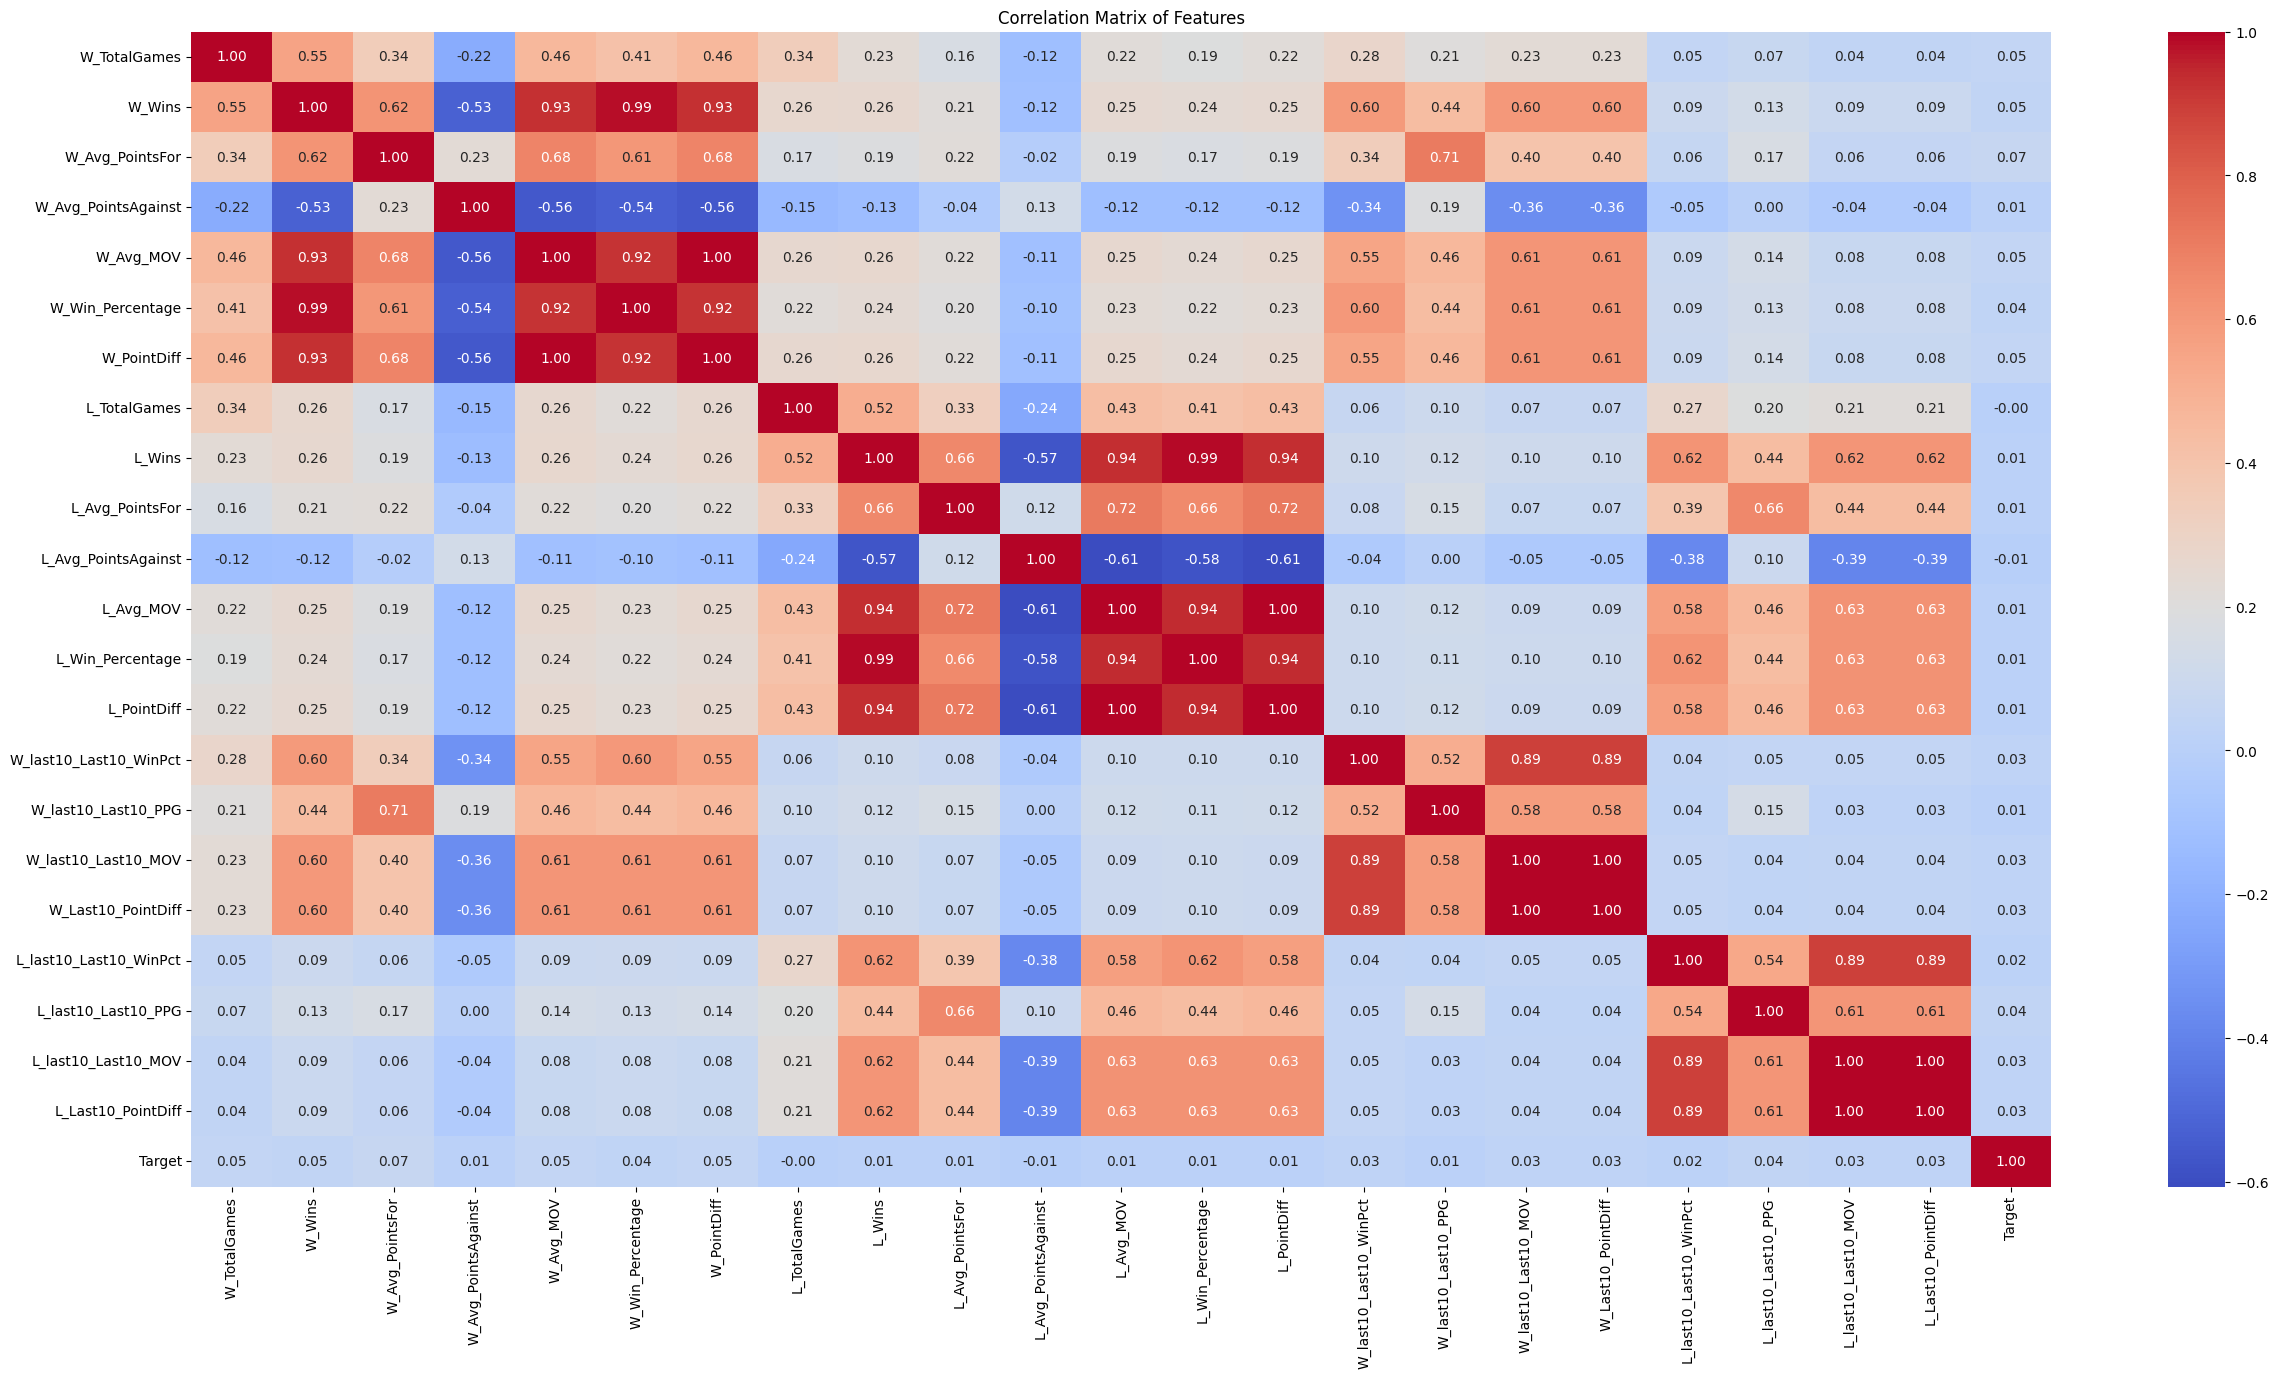

In [1864]:
# Correlation Matrix of Features
candidate_features = [
    # Winner-side aggregated pre-game features
    'W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 
    'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff',
    # Loser-side aggregated pre-game features
    'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 
    'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff',
    # Winner-side recent form (last 10) metrics
    'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPG', 
    'W_last10_Last10_MOV', 'W_Last10_PointDiff',
    # Loser-side recent form (last 10) metrics
    'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPG', 
    'L_last10_Last10_MOV', 'L_Last10_PointDiff',
    # Contextual/categorical features
    'WLoc', 'CurrentForm_Flag',
    # Target label
    'Target'
]

# Here we take a look at what features are currently in the tournament_data_2024_2025_update DataFrame
available_columns = set(tournament_data_2024_2025_update.columns)

# I was running into an issue where there were more columns than expected. This will make sure that only the features that are in the candidate_features list are used
final_features = [feat for feat in candidate_features if feat in available_columns]
df_filtered = tournament_data_2024_2025_update[final_features].copy()


# Here we need to define the non numerical features
non_numerical_features = ['WLoc', 'CurrentForm_Flag']

# Here we will create a correlation matrix to see how the features are correlated with each other
correlation_matrix = df_filtered .drop(columns=non_numerical_features).corr()

# Using seaborn to create a heatmap of the correlation matrix
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

### Modeling for 2024-2025 Season

In [1865]:
# First, we will define the candidate features that we want to use for modeling
candidate_features = [
    # Winner-side aggregated pre-game features
    'W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 
    'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff',
    # Loser-side aggregated pre-game features
    'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 
    'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff',
    # Winner-side recent form (last 10) metrics
    'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPG', 
    'W_last10_Last10_MOV', 'W_Last10_PointDiff',
    # Loser-side recent form (last 10) metrics
    'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPG', 
    'L_last10_Last10_MOV', 'L_Last10_PointDiff',
    # Contextual/categorical features
    'WLoc', 'CurrentForm_Flag',
    # Target label
    'Target'
]

# Here we take a look at what features are currently in the tournament_data_2024_2025_update DataFrame
available_columns = set(tournament_data_2024_2025_update.columns)

# I was running into an issue where there were more columns than expected. This will make sure that only the features that are in the candidate_features list are used
final_features = [feat for feat in candidate_features if feat in available_columns]
df_filtered = tournament_data_2024_2025_update[final_features].copy()


# For reproducibility we will use a random_state of 42
random_state = 42

# We will first split the data into training and test set. We will use a 80-20 split
# The stratify parameter will ensure that the target variable is balanced in both the training and test set
# This makes sure taht the proportion of each class in the Target variable is the same in both the training and test set
# This reduces sampling bias
train_val, test = train_test_split(df_filtered, test_size=0.2, random_state=random_state, stratify=df_filtered['Target'])

# Here we further split the training and validation set. We will use a 75-25 split
train, val = train_test_split(train_val, test_size=0.25, random_state=random_state, stratify=train_val['Target'])

# Here we one-hot encode the categorical columns
categorical_columns = [col for col in ['WLoc', 'CurrentForm_Flag'] if col in final_features]

# We will use the OneHotEncoder from scikit-learn
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(train[categorical_columns])  

def transform_with_encoder(df, encoder, categorical_columns):
    """
    Purpose: One-hot encode the categorical columns in the DataFrame using the provided encoder.
    Input:
    - df (pd.DataFrame): DataFrame with categorical columns to encode
    - encoder (OneHotEncoder): Fitted OneHotEncoder object
    - categorical_columns (list): List of categorical columns to encode
    Output: df_transformed (pd.DataFrame): DataFrame with categorical columns encoded
    """
    # Here we define the encoded array
    encoded_array = encoder.transform(df[categorical_columns])
    # The encoded array is converted to a DataFrame
    encoded_df = pd.DataFrame(encoded_array, index=df.index, columns=encoder.get_feature_names_out(categorical_columns))
    df_transformed = df.drop(columns=categorical_columns)
    df_transformed = pd.concat([df_transformed, encoded_df], axis=1)
    return df_transformed

# We use the transform_with_encoder function to encode the categorical columns in the training, validation, and test set
train_encoded = transform_with_encoder(train, encoder, categorical_columns)
val_encoded = transform_with_encoder(val, encoder, categorical_columns)
test_encoded = transform_with_encoder(test, encoder, categorical_columns)

label = "Target"
save_path = "this_season_models"

predictor = TabularPredictor(label=label, path=save_path).fit(
    train_data=train_encoded,
    presets='best_quality',
    num_bag_folds=5,         # Here we incorporate k-fold cross-validation with 5 folds
    num_stack_levels=1,      # We will use a single layer stack ensemble. Stacking is a form of ensemble learning that will combine the predictions of multiple models
    # Essentially a meta model is trained with the predictions of the base models
    # This will help improve the overall performance of the model
    use_bag_holdout=True,    # Use out-of-fold predictions for stacking
    calibrate_decision_threshold=True,
    # The models I want to experiment with are XGBoost, LightGBM, CatBoost, Random Forest, Extra Trees, and Neural Network
    hyperparameters={
        "XGB": {},
        "GBM": {},
        "CAT": {},
        "RF": {},
        "XT": {},
        "NN_TORCH": {},
    }
)

# Here we print the summary of the model
predictor.fit_summary()

val_performance = predictor.evaluate(val_encoded)
print("Validation set performance:")
print(val_performance)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:14:59 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T8122
CPU Count:          8
Memory Avail:       1.12 GB / 8.00 GB (14.0%)
Disk Space Avail:   13.87 GB / 228.27 GB (6.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/Users/sveerisetti/Desktop/MM_Kaggle/this_season_models"
Train Data Rows:    6748
Train Data Columns: 24
Label Column:       Target
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observe

*** Summary of fit() ***
Estimated performance of each model:
                    model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2   0.845926    accuracy       0.646507   19.562845                0.000346           0.066369            2       True          7
1     WeightedEnsemble_L3   0.840000    accuracy       1.791621   92.346028                0.003085           0.119947            3       True         14
2          XGBoost_BAG_L2   0.837037    accuracy       1.754102   91.362524                0.468077           1.585458            2       True         12
3         LightGBM_BAG_L2   0.835556    accuracy       1.320459   90.640623                0.034435           0.863557            2       True          8
4          XGBoost_BAG_L1   0.834074    accuracy       0.147824    2.411274                0.147824           2.411274            1       True          5
5         CatB

/Users/sveerisetti/Library/Python/3.9/lib/python/site-packages/autogluon/core/utils/plots.py:169: UserWarning:

AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"



Validation set performance:
{'accuracy': 0.8493333333333334, 'balanced_accuracy': 0.8494740734653627, 'mcc': 0.6995196250280117, 'roc_auc': 0.9319234878031821, 'f1': 0.8466757123473542, 'precision': 0.8674698795180723, 'recall': 0.8268551236749117}


In [1866]:
# Eval on the Test Set 
test_performance = predictor.evaluate(test_encoded)
print("Test set performance:")
print(test_performance)

Test set performance:
{'accuracy': 0.8408888888888889, 'balanced_accuracy': 0.8407997623216622, 'mcc': 0.681955258232729, 'roc_auc': 0.9223294373471052, 'f1': 0.8439407149084568, 'precision': 0.8330464716006885, 'recall': 0.8551236749116607}


### ROC Curve for Regular Season Model 

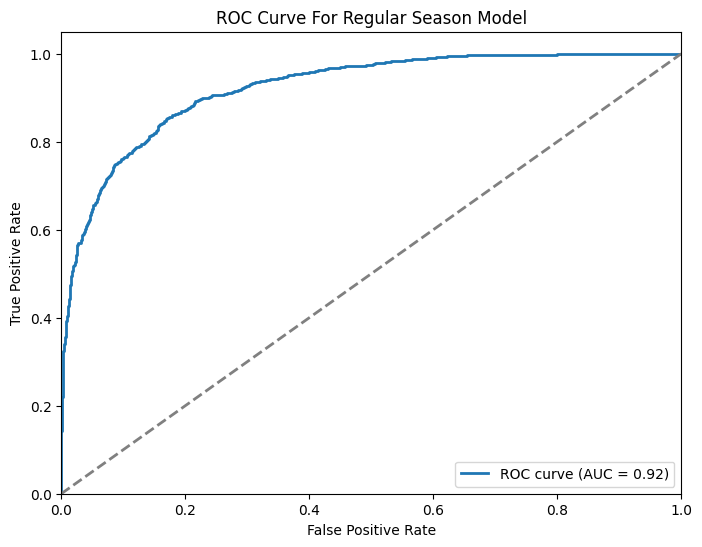

In [1867]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# The true predictions are the actual values of the target variable
y_true = test_encoded[label].values

# We will get the predicted probabilities for the test set
y_proba_df = predictor.predict_proba(test_encoded)
y_proba = y_proba_df[1].values

# Here we use roc_curve to get the true positive rate, false positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# Calculate the Area Under the Curve (AUC) score.
roc_auc = auc(fpr, tpr)

# Plot the ROC curve.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Regular Season Model')
plt.legend(loc="lower right")
plt.show()


### PR Curve

/var/folders/85/1l0v0zxd5q31ry0x76fqfv0c0000gn/T/ipykernel_51361/1563784633.py:14: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



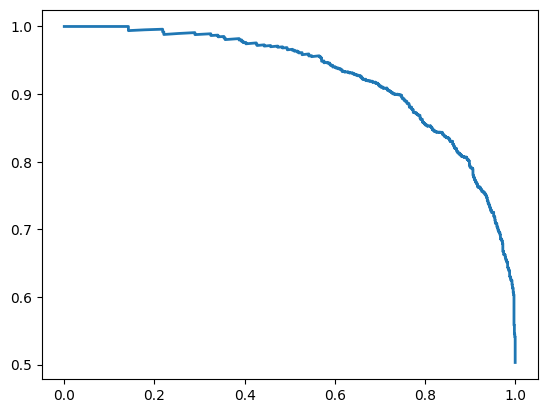

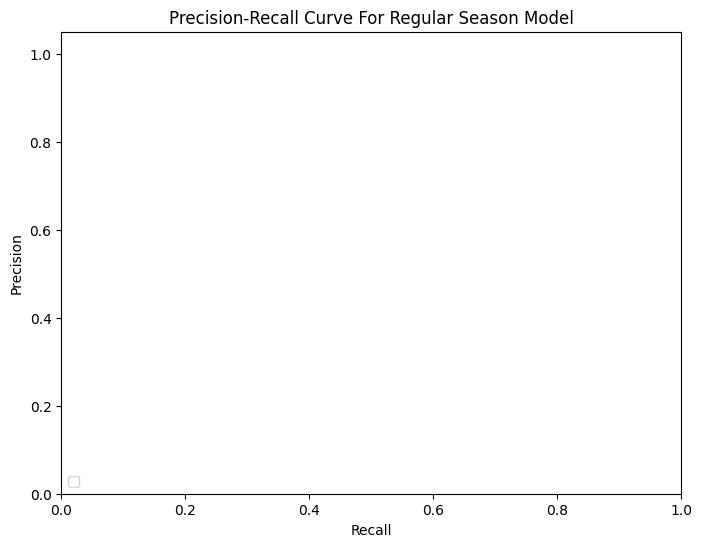

In [1868]:
# Here we compute the precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_true, y_proba)

# Here we calculate the average precision score
avg_precision = average_precision_score(y_true, y_proba)

plt.plot(recall, precision, lw=2, label=f'PR curve (AP = {avg_precision:0.2f})')
plt.figure(figsize=(8, 6))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve For Regular Season Model')
plt.legend(loc="lower left")
plt.show()


### Confusion Matrix for Regular Season Model

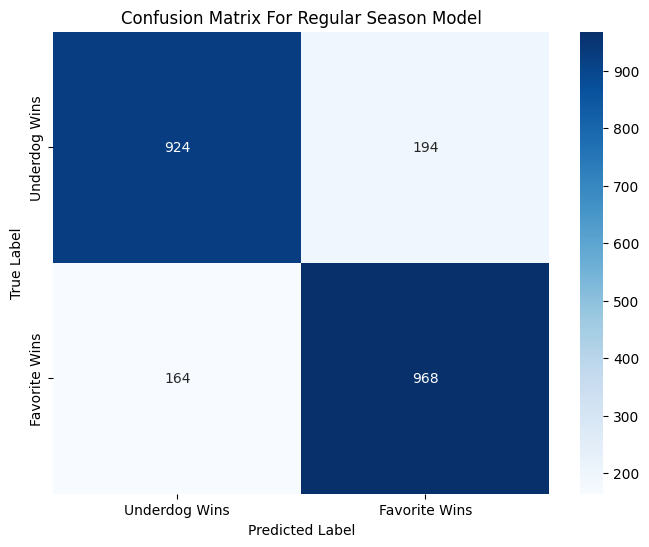

In [1869]:
# Generate predictions on the test set
test_predictions = predictor.predict(test_encoded)  

# Compute confusion matrix
cm = confusion_matrix(test['Target'], test_predictions)

# Define class labels
labels = ["Underdog Wins", "Favorite Wins"]  

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For Regular Season Model")
plt.show()

# Regular Season 2024-2025 Model Training, Predictions, and Analysis

In [1870]:
def compute_team_aggregated_metrics(df):
    """
    Compute aggregated team-level metrics from detailed game results.
    Each team (for each season) will have metrics such as:
      - TotalGames
      - Wins and Losses
      - WinPercentage
      - Total and Average Points For/Against
      - Average Margin (AvgPointsFor - AvgPointsAgainst)
    
    This function uses the detailed game results DataFrame, where each row corresponds
    to a game and contains separate columns for winning and losing teams.
    
    Parameters:
        df (DataFrame): men_regular_season_detailed_game_results with columns:
            ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', ...]
    
    Returns:
        team_metrics (DataFrame): Aggregated metrics with columns:
            ['Season', 'TeamID', 'TotalGames', 'Wins', 'Losses', 'WinPercentage',
             'TotalPointsFor', 'TotalPointsAgainst', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgMargin']
    """

    # Here we will create a copy of the DataFrame to avoid modifying the original
    winners = df[['Season', 'WTeamID', 'WScore', 'LScore']].copy()
    winners = winners.rename(columns={
        'WTeamID': 'TeamID',
        'WScore': 'PointsFor',
        'LScore': 'PointsAgainst'
    })
    winners['Win'] = 1  

    # Here we will group the winners DataFrame by Season and TeamID
    # We will aggregate the number of wins, total points for, total points against, and the number of games as the winner
    winners_group = winners.groupby(['Season', 'TeamID']).agg(
        Wins=('Win', 'sum'),
        TotalPointsFor_win=('PointsFor', 'sum'),
        TotalPointsAgainst_win=('PointsAgainst', 'sum'),
        GamesAsWinner=('TeamID', 'count')
    ).reset_index()
    
    # Here we will create a copy of the DataFrame to avoid modifying the original
    losers = df[['Season', 'LTeamID', 'LScore', 'WScore']].copy()
    losers = losers.rename(columns={
        'LTeamID': 'TeamID',
        'LScore': 'PointsFor',
        'WScore': 'PointsAgainst'
    })
    losers['Win'] = 0
    # Here we will group the losers DataFrame by Season and TeamID
    # We will aggregate the number of losses, total points for, total points against, and the number of games as the loser
    losers_group = losers.groupby(['Season', 'TeamID']).agg(
        Losses=('Win', 'count'),
        TotalPointsFor_lose=('PointsFor', 'sum'),
        TotalPointsAgainst_lose=('PointsAgainst', 'sum'),
        GamesAsLoser=('TeamID', 'count')
    ).reset_index()
    
    # Here we will merge the winners_group and losers_group DataFrames
    # We use outer join to include all teams, even if they have no wins or losses
    team_metrics = pd.merge(winners_group, losers_group, on=['Season', 'TeamID'], how='outer')
    team_metrics = team_metrics.fillna(0)
    
    # Here we will calculate the total games played by each team
    team_metrics['TotalGames'] = team_metrics['GamesAsWinner'] + team_metrics['GamesAsLoser']
    # Here we will calculate the win percentage for each team
    team_metrics['Wins'] = team_metrics['Wins'] 
    # Here we will calculate the loss percentage for each team
    team_metrics['Losses'] = team_metrics['GamesAsLoser']
    # Here we will calculate the win percentage for each team
    team_metrics['WinPercentage'] = team_metrics['Wins'] / team_metrics['TotalGames']
    
    # Total points for and against 
    team_metrics['TotalPointsFor'] = team_metrics['TotalPointsFor_win'] + team_metrics['TotalPointsFor_lose']
    team_metrics['TotalPointsAgainst'] = team_metrics['TotalPointsAgainst_win'] + team_metrics['TotalPointsAgainst_lose']
    
    # Here we calculate the average points for and against for each team 
    team_metrics['AvgPointsFor'] = team_metrics['TotalPointsFor'] / team_metrics['TotalGames']
    team_metrics['AvgPointsAgainst'] = team_metrics['TotalPointsAgainst'] / team_metrics['TotalGames']
    
    # Here we calculate the average margin of victory for each team
    team_metrics['AvgMargin'] = team_metrics['AvgPointsFor'] - team_metrics['AvgPointsAgainst']
    
    # Final order of columns
    team_metrics = team_metrics[['Season', 'TeamID', 'TotalGames', 'Wins', 'Losses', 'WinPercentage', 
                                 'TotalPointsFor', 'TotalPointsAgainst', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgMargin']]
    
    return team_metrics

# Filter the detailed game results for the 2024-2025 seasons
men_regular_season_detailed_game_results_2024_2025 = men_regular_season_detailed_game_results[
    (men_regular_season_detailed_game_results['Season'] >= 2024) & 
    (men_regular_season_detailed_game_results['Season'] <= 2025)
]

# Here we use the compute_team_aggregated_metrics function to calculate the team-level aggregated metrics
team_metrics_df = compute_team_aggregated_metrics(men_regular_season_detailed_game_results_2024_2025)

# Here we get the first 5 rows of the team_metrics_df DataFrame
print("Team-level Aggregated Metrics:")
print(team_metrics_df.head())

Team-level Aggregated Metrics:
   Season  TeamID  TotalGames  Wins  Losses  WinPercentage  TotalPointsFor  \
0    2024    1101          31    14      17       0.451613            2200   
1    2024    1102          31     9      22       0.290323            2051   
2    2024    1103          32    22      10       0.687500            2315   
3    2024    1104          32    21      11       0.656250            2904   
4    2024    1105          33    11      22       0.333333            2267   

   TotalPointsAgainst  AvgPointsFor  AvgPointsAgainst  AvgMargin  
0                2282     70.967742         73.612903  -2.645161  
1                2243     66.161290         72.354839  -6.193548  
2                2138     72.343750         66.812500   5.531250  
3                2594     90.750000         81.062500   9.687500  
4                2501     68.696970         75.787879  -7.090909  


### Round Predictions Based on Regular Season Model 

In [1871]:
# Compute team-level metrics for 2025
def compute_team_metrics_2025(df):
    """
    Purpose: Compute team-level aggregated metrics for Season=2025.
    Input: df (pd.DataFrame): DataFrame with detailed game results
    Output: team_metrics_2025 (pd.DataFrame): Aggregated metrics for Season=2025
    """
    # Here we will filter the DataFrame to only include the games from the 2025 season
    df_2025 = df[df['Season'] == 2025].copy()
    if df_2025.empty:
        print("DEBUG: No rows found for Season=2025!")
    
    # Here we will gather the winner and loser information
    winners = df_2025[['Season','DayNum','WTeamID','WScore','LScore']].copy()
    winners.rename(columns={'WTeamID':'TeamID','WScore':'PointsFor','LScore':'PointsAgainst'}, inplace=True)
    winners['Win'] = 1

    losers = df_2025[['Season','DayNum','LTeamID','LScore','WScore']].copy()
    losers.rename(columns={'LTeamID':'TeamID','LScore':'PointsFor','WScore':'PointsAgainst'}, inplace=True)
    losers['Win'] = 0

    # We concatenate the winners and losers DataFrames
    logs = pd.concat([winners, losers], ignore_index=True).sort_values(by=['TeamID','DayNum'])
    
    # For the season level aggregation we group by the team and calculate the total games, wins, losses, total points for, and total points against
    season_agg = logs.groupby('TeamID', as_index=False).agg(
        TotalGames=('TeamID', 'count'),
        Wins=('Win', 'sum'),
        TotalPointsFor=('PointsFor', 'sum'),
        TotalPointsAgainst=('PointsAgainst', 'sum')
    )

    # Calculate additional metrics such as the loss count, win percentage, average points for, average points against, and average margin
    season_agg['Losses'] = season_agg['TotalGames'] - season_agg['Wins']
    season_agg['WinPercentage'] = season_agg['Wins'] / season_agg['TotalGames'].replace(0, 1)
    season_agg['AvgPointsFor'] = season_agg['TotalPointsFor'] / season_agg['TotalGames'].replace(0, 1)
    season_agg['AvgPointsAgainst'] = season_agg['TotalPointsAgainst'] / season_agg['TotalGames'].replace(0, 1)
    season_agg['AvgMargin'] = season_agg['AvgPointsFor'] - season_agg['AvgPointsAgainst']

    # Compute rolling 10-game metrics per team
    def compute_rolling_10(g):
        g['Last10_Wins'] = g['Win'].rolling(window=10, min_periods=1).sum()
        g['Last10_PtsFor'] = g['PointsFor'].rolling(window=10, min_periods=1).sum()
        g['Last10_PtsAgainst'] = g['PointsAgainst'].rolling(window=10, min_periods=1).sum()
        return g
    
    # Based on the logs DataFrame, we group by the team and apply the compute_rolling_10 function
    # This will calculate the last 10 game wins, points for, and points against for each team
    logs = logs.groupby('TeamID', group_keys=False).apply(compute_rolling_10)
    last10 = logs.groupby('TeamID', as_index=False).tail(1)
    last10['Last10_WinPct'] = last10['Last10_Wins'] / 10.0
    last10['Last10_PPG'] = last10['Last10_PtsFor'] / 10.0
    last10['Last10_OppPG'] = last10['Last10_PtsAgainst'] / 10.0
    last10['Last10_MOV'] = last10['Last10_PPG'] - last10['Last10_OppPG']
    last10['Last10_PointDiff'] = last10['Last10_MOV']
    
    # Merge the season-level and last-10 game metrics
    final_last10 = last10[['TeamID','Last10_WinPct','Last10_PPG','Last10_OppPG','Last10_MOV','Last10_PointDiff']].copy()
    team_metrics_2025 = pd.merge(season_agg, final_last10, on='TeamID', how='left').fillna(0)
    team_metrics_2025['Season'] = 2025
    team_metrics_2025 = team_metrics_2025[[
        'Season','TeamID','TotalGames','Wins','Losses','WinPercentage',
        'TotalPointsFor','TotalPointsAgainst','AvgPointsFor','AvgPointsAgainst','AvgMargin',
        'Last10_WinPct','Last10_PPG','Last10_OppPG','Last10_MOV','Last10_PointDiff'
    ]]
    return team_metrics_2025


def build_matchup_row_2025(team_lower, team_higher, team_metrics_df):
    """
    Purpose: Build a matchup row for the 2025 season using team metrics.
    Input:
      - team_lower (int): TeamID of the lower-seeded team
      - team_higher (int): TeamID of the higher-seeded team
      - team_metrics_df (pd.DataFrame): DataFrame with team-level metrics for 2025
    Output: matchup (pd.DataFrame): DataFrame with matchup features
    """

    # Here we will filter the team_metrics_df DataFrame to get the metrics for the lower and higher seeded teams
    lr = team_metrics_df[team_metrics_df['TeamID'] == team_lower]
    hr = team_metrics_df[team_metrics_df['TeamID'] == team_higher]
    if lr.empty:
        print(f"DEBUG: No metrics row for TeamID={team_lower}.")
        return None
    if hr.empty:
        print(f"DEBUG: No metrics row for TeamID={team_higher}.")
        return None
    
    # We use iloc[0] to get the first row of the DataFrame
    lr = lr.iloc[0]
    hr = hr.iloc[0]
    
    matchup = {
        # Lower seeded team metrics
        'W_TotalGames': lr['TotalGames'],
        'W_Wins': lr['Wins'],
        'W_Avg_PointsFor': lr['AvgPointsFor'],
        'W_Avg_PointsAgainst': lr['AvgPointsAgainst'],
        'W_Avg_MOV': lr['AvgMargin'],
        'W_Win_Percentage': lr['WinPercentage'],
        'W_PointDiff': lr['AvgMargin'],
        'W_last10_Last10_WinPct': lr['Last10_WinPct'],
        'W_last10_Last10_PPG': lr['Last10_PPG'],
        'W_last10_Last10_OppPG': lr['Last10_OppPG'],
        'W_last10_Last10_MOV': lr['Last10_MOV'],
        'W_Last10_PointDiff': lr['Last10_PointDiff'],
        # Higher seeded team metrics
        'L_TotalGames': hr['TotalGames'],
        'L_Wins': hr['Wins'],
        'L_Avg_PointsFor': hr['AvgPointsFor'],
        'L_Avg_PointsAgainst': hr['AvgPointsAgainst'],
        'L_Avg_MOV': hr['AvgMargin'],
        'L_Win_Percentage': hr['WinPercentage'],
        'L_PointDiff': hr['AvgMargin'],
        'L_last10_Last10_WinPct': hr['Last10_WinPct'],
        'L_last10_Last10_PPG': hr['Last10_PPG'],
        'L_last10_Last10_OppPG': hr['Last10_OppPG'],
        'L_last10_Last10_MOV': hr['Last10_MOV'],
        'L_Last10_PointDiff': hr['Last10_PointDiff'],
        'WLoc': 'N',
        'CurrentForm_Flag': 1
    }
    return pd.DataFrame([matchup])


def process_matchups(round_name, matchups_info, team_metrics_2025, mteams, men_tournament_seeds_2025, encoder, predictor):
    """
    Purpose: Process a given round's matchup info.
    Input: 
    - round_name (str): Name of the round
    - matchups_info (list): List of matchup dictionaries
    - team_metrics_2025 (pd.DataFrame): DataFrame with team metrics for 2025
    - mteams (pd.DataFrame): DataFrame with team name mappings
    - men_tournament_seeds_2025 (pd.DataFrame): DataFrame with tournament seeds for 2025
    - encoder (OneHotEncoder): Fitted OneHotEncoder object
    - predictor (TabularPredictor): Trained TabularPredictor model
    Returns:
      - full matchup DataFrame (with features) 
      - final submission DataFrame (columns: ID, Region, LowerTeamName, HigherTeamName, Pred)
    """

    # Empty list to store matchup rows
    matchup_list = []

    # For each match in the matchups_info list, we will build a matchup row
    for m in matchups_info:
        region = m['Region']
        t1_name = m['Team1']
        t2_name = m['Team2']
        
        try:
            # The lookup_team_id function will return the TeamID and the matched team name
            team1_id, matched1 = lookup_team_id(t1_name, mteams)
            team2_id, matched2 = lookup_team_id(t2_name, mteams)
        except ValueError as e:
            print(e)
            continue

        # We get the seed information regarding each team 
        t1_seed_row = men_tournament_seeds_2025[men_tournament_seeds_2025['TeamID'] == team1_id]
        t2_seed_row = men_tournament_seeds_2025[men_tournament_seeds_2025['TeamID'] == team2_id]
        if t1_seed_row.empty or t2_seed_row.empty:
            print(f"DEBUG: Missing seed info for TeamID {team1_id} or {team2_id}")
            continue
        
        team1_seed_str = t1_seed_row.iloc[0]['Seed']
        team2_seed_str = t2_seed_row.iloc[0]['Seed']

        # We use seed_to_int to convert the seed string to an integer
        team1_seed_int = seed_to_int(team1_seed_str)
        team2_seed_int = seed_to_int(team2_seed_str)
        if team1_seed_int is None or team2_seed_int is None:
            print(f"DEBUG: Could not parse seeds: {team1_seed_str}, {team2_seed_str}")
            continue
        
        # The lower seed is the better team on paper 
        if team1_seed_int < team2_seed_int:
            lower_id, lower_name = team1_id, matched1
            higher_id, higher_name = team2_id, matched2
        else:
            lower_id, lower_name = team2_id, matched2
            higher_id, higher_name = team1_id, matched1
        
        # We will build the matchup row for the lower and higher seeded teams
        row_df = build_matchup_row_2025(lower_id, higher_id, team_metrics_2025)
        if row_df is None:
            print(f"DEBUG: Could not build row for {t1_name} vs. {t2_name} (IDs: {lower_id} vs {higher_id}).")
            continue
        
        # Additional columns for the matchup
        row_df['Region'] = region
        row_df['LowerTeamName'] = lower_name
        row_df['HigherTeamName'] = higher_name
        row_df['ID'] = f"2025_{lower_id}_{higher_id}"
        matchup_list.append(row_df)
    
    # Ifthere i a matchup list, we will concatenate the rows to create the full matchup DataFrame
    if matchup_list:
        all_matchups_df = pd.concat(matchup_list, ignore_index=True)
    else:
        all_matchups_df = pd.DataFrame()
    
    print(f"DEBUG ({round_name}): Built {len(all_matchups_df)} matchup rows from {len(matchups_info)} requested games.")
    
    # Only proceed if there are matchups to predict
    if all_matchups_df.empty:
        print(f"{round_name}: No matchups to predict (aggregator or name lookups failed).")
        return all_matchups_df, None
    else:
        print(f"DEBUG ({round_name}): all_matchups_df columns:", list(all_matchups_df.columns))
        categorical_columns = ['WLoc', 'CurrentForm_Flag']
        all_matchups_encoded = transform_with_encoder(all_matchups_df, encoder, categorical_columns)
        predicted_probs = predictor.predict_proba(all_matchups_encoded)
        all_matchups_df['Pred'] = predicted_probs[1]
        final_submission = all_matchups_df[['ID','Region','LowerTeamName','HigherTeamName','Pred']].copy()
        return all_matchups_df, final_submission


In [1872]:

# Here we compute team metrics using the compute_team_metrics_2025 function
team_metrics_2025 = compute_team_metrics_2025(men_regular_season_detailed_game_results)
print("DEBUG: team_metrics_2025 shape:", team_metrics_2025.shape)

# Rounds including Round 1, Round 2, Sweet 16, Elite 8, Final Four, and Championship
rounds = {
    "Round 1": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Alabama St'},  
        {'Region': 'South', 'Team1': 'Louisville', 'Team2': 'Creighton'},
        {'Region': 'South', 'Team1': 'Michigan', 'Team2': 'UC San Diego'},
        {'Region': 'South', 'Team1': 'Texas A&M', 'Team2': 'Yale'},
        {'Region': 'South', 'Team1': 'Mississippi', 'Team2': 'North Carolina'},  
        {'Region': 'South', 'Team1': 'Iowa St', 'Team2': 'Lipscomb'},
        {'Region': 'South', 'Team1': 'Marquette', 'Team2': 'New Mexico'},
        {'Region': 'South', 'Team1': 'Michigan St', 'Team2': 'Bryant'},
        {'Region': 'East', 'Team1': 'Duke', 'Team2': "Mt St Mary's"},
        {'Region': 'East', 'Team1': 'Mississippi St', 'Team2': 'Baylor'},
        {'Region': 'East', 'Team1': 'Oregon', 'Team2': 'Liberty'},
        {'Region': 'East', 'Team1': 'Arizona', 'Team2': 'Akron'},
        {'Region': 'East', 'Team1': 'BYU', 'Team2': 'VCU'},
        {'Region': 'East', 'Team1': 'Wisconsin', 'Team2': 'Montana'},
        {'Region': 'East', 'Team1': "St Mary's CA", 'Team2': 'Vanderbilt'},
        {'Region': 'East', 'Team1': 'Alabama', 'Team2': 'Robert Morris'},
        {'Region': 'Midwest', 'Team1': 'Houston', 'Team2': 'SIUE'},
        {'Region': 'Midwest', 'Team1': 'Gonzaga', 'Team2': 'Georgia'},
        {'Region': 'Midwest', 'Team1': 'Clemson', 'Team2': 'McNeese St'},
        {'Region': 'Midwest', 'Team1': 'Purdue', 'Team2': 'High Point'},
        {'Region': 'Midwest', 'Team1': 'Illinois', 'Team2': 'Texas'},  
        {'Region': 'Midwest', 'Team1': 'Kentucky', 'Team2': 'Troy'},
        {'Region': 'Midwest', 'Team1': 'UCLA', 'Team2': 'Utah St'},
        {'Region': 'Midwest', 'Team1': 'Tennessee', 'Team2': 'Wofford'},
        {'Region': 'West', 'Team1': 'Florida', 'Team2': 'Norfolk St'},
        {'Region': 'West', 'Team1': 'Connecticut', 'Team2': 'Oklahoma'},
        {'Region': 'West', 'Team1': 'Memphis', 'Team2': 'Colorado St'},
        {'Region': 'West', 'Team1': 'Maryland', 'Team2': 'Grand Canyon'},
        {'Region': 'West', 'Team1': 'Missouri', 'Team2': 'Drake'},
        {'Region': 'West', 'Team1': 'Texas Tech', 'Team2': 'UNC Wilmington'},
        {'Region': 'West', 'Team1': 'Kansas', 'Team2': 'Arkansas'},
        {'Region': 'West', 'Team1': "St John's", 'Team2': 'Omaha'},
    ],
    "Round 2": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Louisville'}, 
        {'Region': 'South', 'Team1': 'Texas A&M', 'Team2': 'Michigan'},
        {'Region': 'South', 'Team1': 'North Carolina', 'Team2': 'Lipscomb'},  
        {'Region': 'South', 'Team1': 'Marquette', 'Team2': 'Bryant'},
        {'Region': 'East', 'Team1': 'Duke', 'Team2': "Baylor"},
        {'Region': 'East', 'Team1': 'Arizona', 'Team2': 'Oregon'},
        {'Region': 'East', 'Team1': 'Wisconsin', 'Team2': 'BYU'},
        {'Region': 'East', 'Team1': 'Alabama', 'Team2': "St Mary's CA"},
        {'Region': 'Midwest', 'Team1': 'Houston', 'Team2': 'Gonzaga'},
        {'Region': 'Midwest', 'Team1': 'Purdue', 'Team2': 'McNeese St'}, 
        {'Region': 'Midwest', 'Team1': 'Kentucky', 'Team2': 'Illinois'},
        {'Region': 'Midwest', 'Team1': 'Tennessee', 'Team2': 'UCLA'},
        {'Region': 'West', 'Team1': 'Florida', 'Team2': 'Connecticut'},
        {'Region': 'West', 'Team1': 'Maryland', 'Team2': 'Colorado St'},
        {'Region': 'West', 'Team1': 'Texas Tech', 'Team2': 'Drake'},
        {'Region': 'West', 'Team1': "St John's", 'Team2': 'Arkansas'},
    ],
    "Sweet 16": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Texas A&M'}, 
        {'Region': 'South', 'Team1': 'North Carolina', 'Team2': 'Bryant'},
        {'Region': 'East', 'Team1': 'Duke', 'Team2': 'Arizona'},
        {'Region': 'East', 'Team1': 'Alabama', 'Team2': 'BYU'},
        {'Region': 'Midwest', 'Team1': 'Gonzaga', 'Team2': 'McNeese St'}, 
        {'Region': 'Midwest', 'Team1': 'Tennessee', 'Team2': 'Kentucky'},
        {'Region': 'West', 'Team1': 'Florida', 'Team2': 'Maryland'},
        {'Region': 'West', 'Team1': 'Arkansas', 'Team2': 'Drake'},
    ],
    "Elite 8": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Bryant'}, 
        {'Region': 'East', 'Team1': 'Duke', 'Team2': 'Alabama'},
        {'Region': 'Midwest', 'Team1': 'Gonzaga', 'Team2': 'Kentucky'}, 
        {'Region': 'West', 'Team1': 'Florida', 'Team2': 'Drake'},
    ],
    "Final 4": [
        {'Region': 'South', 'Team1': 'Auburn', 'Team2': 'Florida'}, 
        {'Region': 'East', 'Team1': 'Alabama', 'Team2': 'Gonzaga'},
    ],
    "Final Round": [
        {'Region': 'South', 'Team1': 'Florida', 'Team2': 'Alabama'}, 
    ]
}

# The final tables dictionary will store the final submission DataFrames for each round
final_tables = {}
for round_name, matchups_info in rounds.items():
    _, final_submission = process_matchups(
        round_name,
        matchups_info,
        team_metrics_2025,
        mteams,
        men_tournament_seeds_2025,
        encoder,
        predictor
    )
    if final_submission is not None:
        print(f"\n{round_name} Submission:")
        display(final_submission)
        final_tables[round_name] = final_submission

DEBUG: team_metrics_2025 shape: (364, 16)
DEBUG: Team 'Omaha' not found by exact match. Using partial match: ['NE Omaha']
DEBUG (Round 1): Built 32 matchup rows from 32 requested games.
DEBUG (Round 1): all_matchups_df columns: ['W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff', 'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPG', 'W_last10_Last10_MOV', 'W_Last10_PointDiff', 'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff', 'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPG', 'L_last10_Last10_MOV', 'L_Last10_PointDiff', 'WLoc', 'CurrentForm_Flag', 'Region', 'LowerTeamName', 'HigherTeamName', 'ID']

Round 1 Submission:


/var/folders/85/1l0v0zxd5q31ry0x76fqfv0c0000gn/T/ipykernel_51361/290764609.py:49: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/85/1l0v0zxd5q31ry0x76fqfv0c0000gn/T/ipykernel_51361/290764609.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/85/1l0v0zxd5q31ry0x76fqfv0c0000gn/T/ipykernel_51361/290764609.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,ID,Region,LowerTeamName,HigherTeamName,Pred
0,2025_1120_1106,South,Auburn,Alabama St,0.353407
1,2025_1257_1166,South,Louisville,Creighton,0.473113
2,2025_1276_1471,South,Michigan,UC San Diego,0.289158
3,2025_1401_1463,South,Texas A&M,Yale,0.610993
4,2025_1279_1314,South,Mississippi,North Carolina,0.362984
5,2025_1235_1252,South,Iowa St,Lipscomb,0.247083
6,2025_1266_1307,South,Marquette,New Mexico,0.845722
7,2025_1277_1136,South,Michigan St,Bryant,0.208128
8,2025_1181_1291,East,Duke,Mt St Mary's,0.930197
9,2025_1280_1124,East,Mississippi St,Baylor,0.301799


DEBUG (Round 2): Built 16 matchup rows from 16 requested games.
DEBUG (Round 2): all_matchups_df columns: ['W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff', 'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPG', 'W_last10_Last10_MOV', 'W_Last10_PointDiff', 'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff', 'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPG', 'L_last10_Last10_MOV', 'L_Last10_PointDiff', 'WLoc', 'CurrentForm_Flag', 'Region', 'LowerTeamName', 'HigherTeamName', 'ID']

Round 2 Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,2025_1120_1257,South,Auburn,Louisville,0.732810
1,2025_1401_1276,South,Texas A&M,Michigan,0.620833
2,2025_1314_1252,South,North Carolina,Lipscomb,0.473392
3,2025_1266_1136,South,Marquette,Bryant,0.457518
4,2025_1181_1124,East,Duke,Baylor,0.937346
5,2025_1112_1332,East,Arizona,Oregon,0.882537
6,2025_1458_1140,East,Wisconsin,BYU,0.015474
7,2025_1104_1388,East,Alabama,St Mary's CA,0.952327
8,2025_1222_1211,Midwest,Houston,Gonzaga,0.076160
9,2025_1345_1270,Midwest,Purdue,McNeese St,0.174979


DEBUG (Sweet 16): Built 8 matchup rows from 8 requested games.
DEBUG (Sweet 16): all_matchups_df columns: ['W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff', 'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPG', 'W_last10_Last10_MOV', 'W_Last10_PointDiff', 'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff', 'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPG', 'L_last10_Last10_MOV', 'L_Last10_PointDiff', 'WLoc', 'CurrentForm_Flag', 'Region', 'LowerTeamName', 'HigherTeamName', 'ID']

Sweet 16 Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,2025_1120_1401,South,Auburn,Texas A&M,0.946125
1,2025_1314_1136,South,North Carolina,Bryant,0.392381
2,2025_1181_1112,East,Duke,Arizona,0.901707
3,2025_1104_1140,East,Alabama,BYU,0.939519
4,2025_1211_1270,Midwest,Gonzaga,McNeese St,0.952089
5,2025_1397_1246,Midwest,Tennessee,Kentucky,0.167898
6,2025_1196_1268,West,Florida,Maryland,0.708601
7,2025_1116_1179,West,Arkansas,Drake,0.102472


DEBUG (Elite 8): Built 4 matchup rows from 4 requested games.
DEBUG (Elite 8): all_matchups_df columns: ['W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff', 'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPG', 'W_last10_Last10_MOV', 'W_Last10_PointDiff', 'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff', 'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPG', 'L_last10_Last10_MOV', 'L_Last10_PointDiff', 'WLoc', 'CurrentForm_Flag', 'Region', 'LowerTeamName', 'HigherTeamName', 'ID']

Elite 8 Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,2025_1120_1136,South,Auburn,Bryant,0.720091
1,2025_1181_1104,East,Duke,Alabama,0.269109
2,2025_1246_1211,Midwest,Kentucky,Gonzaga,0.304404
3,2025_1196_1179,West,Florida,Drake,0.661746


DEBUG (Final 4): Built 2 matchup rows from 2 requested games.
DEBUG (Final 4): all_matchups_df columns: ['W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff', 'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPG', 'W_last10_Last10_MOV', 'W_Last10_PointDiff', 'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff', 'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPG', 'L_last10_Last10_MOV', 'L_Last10_PointDiff', 'WLoc', 'CurrentForm_Flag', 'Region', 'LowerTeamName', 'HigherTeamName', 'ID']

Final 4 Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,2025_1196_1120,South,Florida,Auburn,0.674553
1,2025_1104_1211,East,Alabama,Gonzaga,0.806130


DEBUG (Final Round): Built 1 matchup rows from 1 requested games.
DEBUG (Final Round): all_matchups_df columns: ['W_TotalGames', 'W_Wins', 'W_Avg_PointsFor', 'W_Avg_PointsAgainst', 'W_Avg_MOV', 'W_Win_Percentage', 'W_PointDiff', 'W_last10_Last10_WinPct', 'W_last10_Last10_PPG', 'W_last10_Last10_OppPG', 'W_last10_Last10_MOV', 'W_Last10_PointDiff', 'L_TotalGames', 'L_Wins', 'L_Avg_PointsFor', 'L_Avg_PointsAgainst', 'L_Avg_MOV', 'L_Win_Percentage', 'L_PointDiff', 'L_last10_Last10_WinPct', 'L_last10_Last10_PPG', 'L_last10_Last10_OppPG', 'L_last10_Last10_MOV', 'L_Last10_PointDiff', 'WLoc', 'CurrentForm_Flag', 'Region', 'LowerTeamName', 'HigherTeamName', 'ID']

Final Round Submission:


,ID,Region,LowerTeamName,HigherTeamName,Pred
0,2025_1196_1104,South,Florida,Alabama,0.215576


### Combined Prediction 

In [1873]:
def blend_predictions(curr_df, hist_df, alpha):
    """
    Purpose: Blends predictions from the current and historical models.
    Inputs:
      curr_df (pd.DataFrame): Current season predictions with a column 'Pred'
      hist_df (pd.DataFrame): Historical predictions with a column 'Pred'
      alpha (float): Weight for current predictions.
    Returns:
      pd.DataFrame: Merged DataFrame with columns:
        ['Region', 'LowerTeamName', 'HigherTeamName', 'Pred_current', 'Pred_hist', 'BlendedPred']
    """

    # Here we rename the 'Pred' column to 'Pred_current' for the current season predictions
    df_current = curr_df.rename(columns={'Pred': 'Pred_current'})
    df_hist = hist_df.rename(columns={'Pred': 'Pred_hist'})
    
    # Merge on on the lower and higher team names via an inner join to make sure we have both predictions
    df_combined = df_current.merge(
        df_hist[['LowerTeamName', 'HigherTeamName', 'Pred_hist']],
        on=['LowerTeamName', 'HigherTeamName'],
        how='inner'
    )
    
    # Here we compute the blended prediction. We do this because we are combining the predictions from two models
    # We apply more weight to the current season predictions than the historical predictions because form really matters in the NCAA MM
    df_combined['BlendedPred'] = alpha * df_combined['Pred_current'] + (1 - alpha) * df_combined['Pred_hist']
    
    # For display, we reorder the columns
    df_combined = df_combined[['Region', 'LowerTeamName', 'HigherTeamName', 
                                 'Pred_current', 'Pred_hist', 'BlendedPred']]
    return df_combined


# Define blending weights per round.
blend_weights = {
    "Round 1": 0.65,
    "Round 2": 0.65,
    "Sweet 16": 0.65,
    "Elite 8": 0.65,
    "Final 4": 0.65,
    "Final Round": 0.65
}

# Dictionary to store the blended results for each round
blended_results = {}

# For each round and alpha value, we will blend the predictions and display the results
for round_name, alpha in blend_weights.items():
    curr_df = final_tables.get(round_name)
    hist_df = final_hist_tables.get(round_name)
    
    if curr_df is None or hist_df is None:
        print(f"Missing predictions for round: {round_name}")
        continue
    
    # We use the blend_predictions function to blend the predictions
    blended_df = blend_predictions(curr_df, hist_df, alpha)
    print(f"\nBlended Predictions for {round_name} (alpha = {alpha}):")
    display(blended_df)
    blended_results[round_name] = blended_df



Blended Predictions for Round 1 (alpha = 0.65):


,Region,LowerTeamName,HigherTeamName,Pred_current,Pred_hist,BlendedPred
0,South,Auburn,Alabama St,0.353407,0.651131,0.457610
1,South,Louisville,Creighton,0.473113,0.469908,0.471991
2,South,Texas A&M,Yale,0.610993,0.551375,0.590126
3,South,Mississippi,North Carolina,0.362984,0.289181,0.337153
4,South,Iowa St,Lipscomb,0.247083,0.285974,0.260695
5,South,Marquette,New Mexico,0.845722,0.615553,0.765163
6,South,Michigan St,Bryant,0.208128,0.274734,0.231440
7,East,Duke,Mt St Mary's,0.930197,0.381950,0.738311
8,East,Mississippi St,Baylor,0.301799,0.172118,0.256411
9,East,Oregon,Liberty,0.579089,0.532713,0.562857



Blended Predictions for Round 2 (alpha = 0.65):


,Region,LowerTeamName,HigherTeamName,Pred_current,Pred_hist,BlendedPred
0,South,Auburn,Louisville,0.732810,0.717412,0.727421
1,South,Texas A&M,Michigan,0.620833,0.198171,0.472901
2,South,North Carolina,Lipscomb,0.473392,0.422731,0.455660
3,South,Marquette,Bryant,0.457518,0.210145,0.370938
4,East,Duke,Baylor,0.937346,0.322228,0.722054
5,East,Arizona,Oregon,0.882537,0.551260,0.766590
6,East,Wisconsin,BYU,0.015474,0.235890,0.092620
7,East,Alabama,St Mary's CA,0.952327,0.760066,0.885036
8,Midwest,Houston,Gonzaga,0.076160,0.720755,0.301768
9,Midwest,Purdue,McNeese St,0.174979,0.277064,0.210709



Blended Predictions for Sweet 16 (alpha = 0.65):


,Region,LowerTeamName,HigherTeamName,Pred_current,Pred_hist,BlendedPred
0,South,Auburn,Texas A&M,0.946125,0.785985,0.890076
1,South,North Carolina,Bryant,0.392381,0.429428,0.405348
2,East,Duke,Arizona,0.901707,0.509685,0.764499
3,East,Alabama,BYU,0.939519,0.573031,0.811248
4,Midwest,Gonzaga,McNeese St,0.952089,0.572750,0.819320
5,Midwest,Tennessee,Kentucky,0.167898,0.211418,0.183130
6,West,Florida,Maryland,0.708601,0.754548,0.724683
7,West,Arkansas,Drake,0.102472,0.627782,0.286331



Blended Predictions for Elite 8 (alpha = 0.65):


,Region,LowerTeamName,HigherTeamName,Pred_current,Pred_hist,BlendedPred
0,South,Auburn,Bryant,0.720091,0.651131,0.695955
1,East,Duke,Alabama,0.269109,0.682952,0.413954
2,Midwest,Kentucky,Gonzaga,0.304404,0.732813,0.454348
3,West,Florida,Drake,0.661746,0.661763,0.661752



Blended Predictions for Final 4 (alpha = 0.65):


,Region,LowerTeamName,HigherTeamName,Pred_current,Pred_hist,BlendedPred
0,South,Florida,Auburn,0.674553,0.407184,0.580974
1,East,Alabama,Gonzaga,0.806130,0.601301,0.734440



Blended Predictions for Final Round (alpha = 0.65):


,Region,LowerTeamName,HigherTeamName,Pred_current,Pred_hist,BlendedPred
0,South,Florida,Alabama,0.215576,0.60477,0.351794
